In [1]:
knitr::opts_chunk$set(echo = TRUE, warning = FALSE, message = FALSE)

# IBM HR Data Analysis
 
### Introduction

This notebook inspects the employee attrition (turnover), which is unavoidable but controllable if a wise and sensitive management policy is applied.

Attrition is critical in the business these days. It's the main problem which highlights in all the organizations. knowing that the organization loses key skills and knowledge. managers and HR administrators are greatly interested in reducing turnover in the organization in such a way that it will contribute to the maximum effectiveness, and progress of the organization because employees are the most treasured assets of an organization. They add value to the organization in terms of quantity and quality as well. Therefore, it is crucial to maintain a permanent and talented workforce.

Attrition, when an organization pushes gently the employees and in a limited level, it can therefore bring advantages to the organization. However, if turnover increases beyond a certain level, the advantages are transformed into disadvantages. Recruiters explain that high attrition rates significantly increase the investment made on employees such as significant investments in time and money need to be made for obtaining skilled employees.

The reasons for the attrition are somehow complicated, and they differ from organization to organization and from country to country, depending on the work culture in each country. In this dataset, we are talking about a company specialized in the computers field in the USA. And it is not possible whatsoever to apply the result to another company or another country.


### Load labraries

In [2]:
library(tidyverse)
library(tidytext)
library(janitor)
library(scales)
library(plotly)
library(glue)
library(patchwork)
library(skimr)
library(GGally)
library(RColorBrewer)

# Model
library(tidymodels)
library(themis)
library(vip)

theme_set(theme_light())

Warning message:
"package 'ggplot2' was built under R version 4.3.1"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'tidytext' was built under R version 4.3.1"
Warning message:
"package 'janitor' was built under R version 4.3.1"

Attaching package: 'janitor'


The following objects are masked from 'package:stats':

    chisq.test, fisher.test



Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr'

## A. EDA

### DATA

#### Read data


In [3]:
myData <- read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv", show_col_types = FALSE)

### About the Dataset

In [4]:
#skim package

result <- skim(myData)
print(result)

── Data Summary ────────────────────────
                           Values
Name                       myData
Number of rows             1470  
Number of columns          35    
_______________________          
Column type frequency:           
  character                9     
  numeric                  26    
________________________         
Group variables            None  

── Variable type: character ────────────────────────────────────────────────────
  skim_variable  n_missing complete_rate min max empty n_unique whitespace
1 Attrition              0             1   2   3     0        2          0
2 BusinessTravel         0             1  10  17     0        3          0
3 Department             0             1   5  22     0        3          0
4 EducationField         0             1   5  16     0        6          0
5 Gender                 0             1   4   6     0        2          0
6 JobRole                0             1   7  25     0        9          0
7 MaritalSta

-   No Missing data.
-   Some numeric variables will be converted to Factor.
-   Many variables are positively skewed.
-   Standard Hours, Employee Count and Employee Number variables are useless for building a model.
-   The Max of Employee Number is greater than the number of dataset's rows.
-   Age variable ranging from 18 years to 60 years.
-   All character variable will be converted to Factor.
-   Distance From Home ranging from 1 to 29.
-   Total Working Years ranging from 0 to 40 years.
-   Monthly Income ranging from 1009 to 19999.
-   Monthly Rate ranging from 2094 to 26999

#### Tidy data and Clean names, Convert to factor and creat age group var!

In [5]:
myData <- myData %>% 
  clean_names() %>% 
  mutate(across(where(is.character), ~ as.factor(str_squish(
                                       str_to_title( 
                                       str_remove_all(.,pattern = "Travel_")))))) %>% 
  mutate_if(is.character, factor) %>% 
  mutate(job_level = factor(job_level),
         performance_rating = factor(performance_rating),
         department = recode_factor(department, "Research & Development" = "R&D", 
                                                "Human Resources" = "HR"),
         age_group = case_when(
                                age > 17 & age <= 25 ~ "18-25",
                                age > 25 & age <= 35 ~ "26-35",
                                age > 35 & age <= 46 ~ "36-45",
                                age > 45 & age <= 50 ~ "46-50",
                                age > 50 & age <= 64 ~ "51-64",        
                                age > 64             ~ "> 64"
                                )
         ) %>% 
  mutate(age_group = factor(
         age_group,
         level = c("18-25","26-35", "36-45","46-50","51-64","> 64")
    )) 

myData %>% glimpse()

Rows: 1,470
Columns: 36
$ age                        <dbl> 41, 49, 37, 33, 27, 32, 59, 30, 38, 36, 35,…
$ attrition                  <fct> Yes, No, Yes, No, No, No, No, No, No, No, N…
$ business_travel            <fct> Rarely, Frequently, Rarely, Frequently, Rar…
$ daily_rate                 <dbl> 1102, 279, 1373, 1392, 591, 1005, 1324, 135…
$ department                 <fct> Sales, R&D, R&D, R&D, R&D, R&D, R&D, R&D, R…
$ distance_from_home         <dbl> 1, 8, 2, 3, 2, 2, 3, 24, 23, 27, 16, 15, 26…
$ education                  <dbl> 2, 1, 2, 4, 1, 2, 3, 1, 3, 3, 3, 2, 1, 2, 3…
$ education_field            <fct> Life Sciences, Life Sciences, Other, Life S…
$ employee_count             <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ employee_number            <dbl> 1, 2, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 1…
$ environment_satisfaction   <dbl> 2, 3, 4, 4, 1, 4, 3, 4, 4, 3, 1, 4, 1, 2, 3…
$ gender                     <fct> Female, Male, Male, Female, Male, Male, Fem…
$ hourly_rate   

That is Better!

Now, lets check the distribution of the class (Attrition)

### Distribution of Target Variable Attrition (label, class):


  No  Yes 
1233  237 

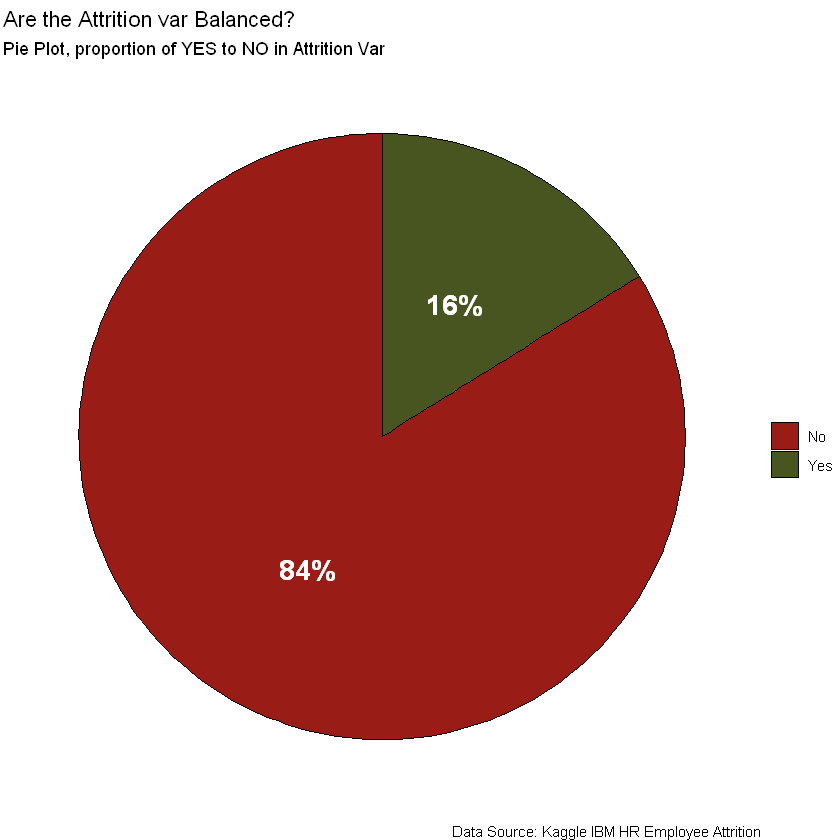

In [6]:
table(myData$attrition)

myData %>% 
  group_by(attrition) %>%
  summarize(counts = n()) %>%
  mutate(prop = (counts / sum(counts)) * 100) %>%
  arrange(desc(prop)) %>% 
ggplot(aes("", counts)) +
  geom_col(
    position = "fill",
    color = "black",
    width = 1,
    aes(fill = factor(attrition))
  ) +
  geom_text(
    aes(label = str_c(round(prop), "%"), group = factor(attrition)),
    position = position_fill(vjust = 0.5),
    color = "white",
    size = 6,
    show.legend = FALSE,
    fontface = "bold"
  ) +
  coord_polar(theta = "y") +
  theme_void() +
  scale_fill_manual (values = c("#991D16", "#485520")) +
  theme_void() +
  labs(
    title = "Are the Attrition var Balanced? ",
    subtitle = "Pie Plot, proportion of YES to NO in Attrition Var",
    caption = "Data Source: Kaggle IBM HR Employee Attrition",
    fill = ""
  )

84% of employees did not quit the company while 16% did quit the company, we are dealing with an imbalanced dataset, that is will guide us determine what will be the best strategy to build our predictive model.

### Create User defined Functions.

#### Proportions features VS Attrition Function

In [7]:
bar_plot_proportions <- function(feature, target){
  
  varCat <- as_label(enquo(feature))
  varCat <- str_to_title(str_replace(varCat, "_", " "))
  
  if(missing(target)) {
    prop_data <- myData %>%  
      group_by({{feature}}) %>% 
      summarise(n = n(), .groups = "drop") %>% 
      ungroup() %>% 
      mutate(percent = str_c(round(n/sum(n)*100,0),"%"),
             just = n/4,
             VarName = fct_reorder(factor({{feature}}), n ),
             label_hjust = case_when(
                  n < quantile(n, probs = 0.85) ~ -0.2,
                  TRUE ~ 1.1,
                ), 
             label_color = case_when(
                  n < quantile(n, probs = 0.85) ~ "black",
                  TRUE ~ "white",
                ))
    
    ggplot(prop_data, aes(x = VarName, y = n, fill = VarName)) +
      geom_col(width = 0.7,
               size = 1,
               show.legend = FALSE) +
      coord_flip() +
      geom_text(show.legend = FALSE,
                aes(y = n, label = str_c(percent,n, sep = " "), hjust = label_hjust,
                    color = label_color) ,
                size = 2.5
      ) +
      scale_y_continuous(expand = expansion(add = c(50, max(prop_data$just)))) +
      scale_fill_viridis_d(direction = -1) +
      scale_color_manual(values = c("black", "white")) +
      theme(
        legend.position = "right",
        plot.background = element_rect(colour = "gray"),
        plot.title.position = "panel",
        plot.title = element_text(size = 10, hjust = 0.5),
        plot.subtitle = element_text(size = 8),
        plot.caption.position = "plot",
        plot.caption = element_text(size = 6, color = "grey"),
        panel.grid = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.y = element_text(size = 8)
      ) +
      labs(
        title = NULL,
        subtitle = NULL,
        x = NULL,
        y = NULL
      ) 
    
  } 
  else {
    
    prop_data <- myData %>%  
      group_by({{feature}},{{target}}) %>% 
      summarise(n = n(), .groups = "drop") %>% 
      ungroup() %>% 
      mutate(percent = str_c(round(n/sum(n)*100,0),"%"),
             just = n/4,
             VarName = reorder_within(factor({{feature}}), n, {{target}}),
             label_hjust = case_when(
                  n < quantile(n, probs = 0.85) ~ -0.2,
                  TRUE ~ 1.1,
                ), 
             label_color = case_when(
                  n < quantile(n, probs = 0.85) ~ "black",
                  TRUE ~ "white",
                ))
    
    ggplot(prop_data, aes(x = VarName, y = n, fill = VarName)) +
      geom_col(width = 0.7,
               size = 1,
               show.legend = FALSE) +
      coord_flip() +
      geom_text(show.legend = FALSE,
                aes(y = n, label = str_c(percent,n, sep = " "), hjust = label_hjust,
                    color = label_color) ,
                size = 2.5
      ) +
      facet_wrap(vars({{target}}), scales = "free_y")+
      scale_y_continuous(expand = expansion(add = c(10, max(prop_data$just)))) +
      scale_x_reordered() +
      scale_fill_viridis_d(direction = -1) +
      scale_color_manual(values = c("black", "white")) +
      theme(
        legend.position = "right",
        strip.background = element_rect(fill = "#CD3B16"),
        strip.text = element_text(color = "white", face = "bold", size = 8),
        plot.background = element_rect(colour = "gray"),
        plot.title.position = "panel",
        plot.title = element_text(size = 10, hjust = 0.5),
        plot.subtitle = element_text(size = 8),
        plot.caption.position = "plot",
        plot.caption = element_text(size = 6, color = "grey"),
        panel.grid = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.y = element_text(size = 6)
      ) +
      labs(
        title = glue("{varCat} VS Attrition"),
        subtitle = NULL,
        x = NULL,
        y = NULL
      )
  }
    
}

Although it a large function and I could create a separate theme to short the function, but for now this way will give me what i need.

#### Plot using user defined function across numeric variables

In [8]:
myData$business_travel

across_features_num_x_plot <- function(x_var, section, subsection, y_var) {
  
  y_axis_label <- c("monthly_income" = "Monthly Income",
                    "monthly_rate" = "Monthly Rate",
                    "percent_salary_hike"= "Percent Salary Hike",
                    "training_times_last_year" = "Training Times Last Year",
                    "years_at_company" = "Years at Company",
                    "years_with_curr_manager" = "Years With Current Manager")[y_var]
  
  
  
  title_text   <- c("monthly_income" = "Monthly Income by ",
                    "monthly_rate" = "Monthly Rate by ",
                    "percent_salary_hike"= "Percent Salary Hike by ",
                    "training_times_last_year" = "Training Times Last Year by ",
                    "years_at_company" = "Years at Company by ",
                    "years_with_curr_manager" = "Years With Current Manager by ")[y_var]

  
  ggplot(myData %>% filter((!!as.name(section)) == subsection),
         aes_string(x = x_var, y = y_var)) +
    geom_point(color = "#16529A") +
    geom_rug(color = "#0E8A41", sides = "lb", position = "jitter") +
    labs(
      title = str_glue(title_text,
                       str_to_title(str_replace_all(x_var, "_", " ")),
                       " (",
                       subsection,
                       " ",
                       str_to_title(str_replace_all(section, "_", " ")), " )"),
      x = NULL,
      y = NULL,
      fill = NULL
    )  +
    theme(plot.title.position = "plot",
          plot.title = element_text(
          hjust = 0,
          face = "bold",
          size = 13,
          color = "#000000"
    ))
  
}

[1] Rarely     Frequently Rarely     Frequently Rarely     Frequently
   [7] Rarely     Rarely     Frequently Rarely     Rarely     Rarely    
  [13] Rarely     Rarely     Rarely     Rarely     Rarely     Non-Travel
  [19] Rarely     Rarely     Non-Travel Rarely     Rarely     Rarely    
  [25] Rarely     Rarely     Frequently Rarely     Rarely     Rarely    
  [31] Rarely     Rarely     Rarely     Rarely     Rarely     Rarely    
  [37] Rarely     Rarely     Rarely     Frequently Rarely     Rarely    
  [43] Rarely     Frequently Frequently Rarely     Non-Travel Rarely    
  [49] Frequently Rarely     Rarely     Rarely     Rarely     Non-Travel
  [55] Rarely     Frequently Frequently Rarely     Rarely     Rarely    
  [61] Rarely     Frequently Rarely     Rarely     Rarely     Rarely    
  [67] Frequently Rarely     Frequently Rarely     Frequently Rarely    
  [73] Rarely     Rarely     Rarely     Rarely     Rarely     Rarely    
  [79] Rarely     Rarely     Rarely     Rarely     Rarely     Non-Travel
  [85] Rarely     Rarely     Rarely     Rarely     Rarely     Rarely    
  [91] Frequently Rarely     Rarely     Frequently Rarely     Rarely    
  [97] Rarely     Non-Travel Rarely     Non-Travel Rarely     Rarely    
 [103] Frequently Rarely     Non-Travel Non-Travel Frequently Rarely    
 [109] Rarely     Rarely     Frequently Frequently Non-Travel Rarely    
 [115] Rarely     Rarely     Rarely     Frequently Rarely     Frequently
 [121] Frequently Non-Travel Rarely     Rarely     Rarely     Rarely    
 [127] Rarely     Rarely     Rarely     Rarely     Frequently Frequently
 [133] Rarely     Rarely     Rarely     Rarely     Frequently Rarely    
 [139] Rarely     Rarely     Rarely     Rarely     Rarely     Rarely    
 [145] Frequently Rarely     Rarely     Frequently Rarely     Rarely    
 [151] Frequently Rarely     Rarely     Rarely     Frequently Non-Travel
 [157] Rarely     Rarely     Rarely     Frequently Rarely     Non-Travel
 [163] Rarely     Rarely     Non-Travel Rarely     Rarely     Rarely    
 [169] Rarely     Rarely     Rarely     Frequently Frequently Non-Travel
 [175] Rarely     Rarely     Rarely     Rarely     Rarely     Rarely    
 [181] Rarely     Rarely     Rarely     Rarely     Rarely     Rarely    
 [187] Rarely     Rarely     Frequently Rarely     Rarely     Rarely    
 [193] Rarely     Non-Travel Non-Travel Rarely     Frequently Non-Travel
 [199] Rarely     Rarely     Frequently Non-Travel Frequently Rarely    
 [205] Rarely     Rarely     Rarely     Frequently Non-Travel Rarely    
 [211] Rarely     Non-Travel Frequently Rarely     Rarely     Rarely    
 [217] Frequently Rarely     Non-Travel Rarely     Rarely     Rarely    
 [223] Frequently Rarely     Non-Travel Rarely     Frequently Frequently
 [229] Frequently Rarely     Rarely     Rarely     Rarely     Rarely    
 [235] Rarely     Rarely     Rarely     Non-Travel Rarely     Rarely    
 [241] Rarely     Non-Travel Rarely     Rarely     Rarely     Frequently
 [247] Rarely     Rarely     Rarely     Frequently Frequently Frequently
 [253] Rarely     Rarely     Rarely     Rarely     Rarely     Rarely    
 [259] Rarely     Frequently Frequently Non-Travel Rarely     Rarely    
 [265] Rarely     Rarely     Rarely     Non-Travel Rarely     Rarely    
 [271] Rarely     Non-Travel Rarely     Rarely     Rarely     Non-Travel
 [277] Rarely     Rarely     Frequently Rarely     Rarely     Rarely    
 [283] Frequently Rarely     Frequently Rarely     Frequently Rarely    
 [289] Rarely     Rarely     Frequently Rarely     Frequently Rarely    
 [295] Frequently Frequently Rarely     Rarely     Frequently Rarely    
 [301] Rarely     Rarely     Rarely     Rarely     Rarely     Non-Travel
 [307] Rarely     Rarely     Non-Travel Rarely     Rarely     Frequently
 [313] Rarely     Frequently Rarely     Frequently Rarely     Rarely    
 [319] Rarely     Rarely     Rarely     Rarely     Rarely     Rarely    
 [325] Rarely     Frequently Frequently Rarely     Frequently

#### Plot using user defined function across catigorical variables

In [9]:
across_features_fact_x_plot <- function(x_var, section, subsection, y_var) {
  
  y_axis_label <- c("monthly_income" = "Monthly Income",
                    "monthly_rate" = "Monthly Rate",
                    "percent_salary_hike"= "Percent Salary Hike",
                    "training_times_last_year" = "Training Times Last Year",
                    "years_at_company" = "Years at Company",
                    "years_with_curr_manager" = "Years With Current Manager")[y_var]
  
  
  
  title_text   <- c("monthly_income" = "Monthly Income by ",
                    "monthly_rate" = "Monthly Rate by ",
                    "percent_salary_hike"= "Percent Salary Hike by ",
                    "training_times_last_year" = "Training Times Last Year by ",
                    "years_at_company" = "Years at Company by ",
                    "years_with_curr_manager" = "Years With Current Manager by ")[y_var]

  
  ggplot(myData %>% filter((!!as.name(section)) == subsection),
         aes_string(x = x_var, y = y_var)) +
    geom_violin(color = "#16529A", fill = "#D3E8FB") +
    geom_dotplot(binaxis = "y", binwidth = 170,  stackdir = "center", color = "#F3C80D")+
    geom_rug(color = "#0E8A41", sides = "lb", position = "jitter") +
    labs(
      title = str_glue(title_text,
                       str_to_title(str_replace_all(x_var, "_", " ")),
                       " (",
                       subsection,
                       " ",
                       str_to_title(str_replace_all(section, "_", " ")), " )"),
      x = NULL,
      y = NULL,
      fill = NULL
    ) +
    theme(plot.title.position = "plot",
          plot.title = element_text(
          hjust = 0,
          face = "bold",
          size = 13,
          color = "#000000"
    ))
  
}

These two function are for plotting numerical variables and categorical variables.

Mainly i will use them to create plots with Monthly Income in the y axis, but it can be used for the variables listed in y_axis_label.

### ggpairs

Rows: 1,470
Columns: 36
$ age                        <dbl> 41, 49, 37, 33, 27, 32, 59, 30, 38, 36, 35,…
$ attrition                  <fct> Yes, No, Yes, No, No, No, No, No, No, No, N…
$ business_travel            <fct> Rarely, Frequently, Rarely, Frequently, Rar…
$ daily_rate                 <dbl> 1102, 279, 1373, 1392, 591, 1005, 1324, 135…
$ department                 <fct> Sales, R&D, R&D, R&D, R&D, R&D, R&D, R&D, R…
$ distance_from_home         <dbl> 1, 8, 2, 3, 2, 2, 3, 24, 23, 27, 16, 15, 26…
$ education                  <dbl> 2, 1, 2, 4, 1, 2, 3, 1, 3, 3, 3, 2, 1, 2, 3…
$ education_field            <fct> Life Sciences, Life Sciences, Other, Life S…
$ employee_count             <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ employee_number            <dbl> 1, 2, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 1…
$ environment_satisfaction   <dbl> 2, 3, 4, 4, 1, 4, 3, 4, 4, 3, 1, 4, 1, 2, 3…
$ gender                     <fct> Female, Male, Male, Female, Male, Male, Fem…
$ hourly_rate   

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


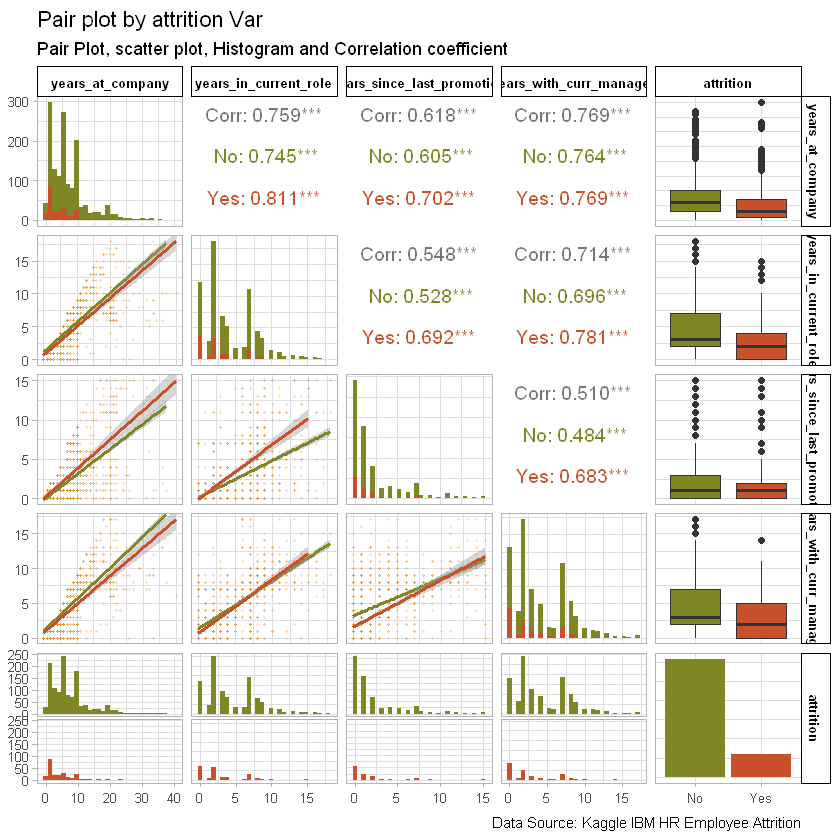

In [10]:
myData %>% glimpse()

myData %>% select(starts_with("years"), attrition) %>% 

ggpairs(
  aes(color = attrition),
  lower = list(continuous = wrap(
    "smooth",
    alpha = 0.2,
    size = 0.5,
    color = "#DE942E"
  )),
  diag = list(continuous = "barDiag"),
  upper = list(continuous = wrap("cor", size = 4))
) +
  scale_color_manual(values = c("#818625", "#C8512B")) +
  scale_fill_manual(values = c("#818625", "#C8512B")) +
  theme(
    axis.text = element_text(size = 8),
    panel.background = element_rect(fill = "white"),
    strip.background = element_rect(fill = "white"),
    strip.background.x = element_rect(colour = "black"),
    strip.background.y = element_rect(colour = "black"),
    strip.text = element_text(color = "black", face = "bold", size = 8)
  ) +
  labs(
    title = "Pair plot by attrition Var",
    subtitle = "Pair Plot, scatter plot, Histogram and Correlation coefficient",
    caption = "Data Source: Kaggle IBM HR Employee Attrition",
    x = NULL,
    y = NULL
  )

I built this pair plot to find if there is a correlation between the variables started with years vs class variable(Attrition)

We can see that there are high positive correlation between these significant variables \*\*\*.

### Proportions

#### Attrition by Gender and Marital status!


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


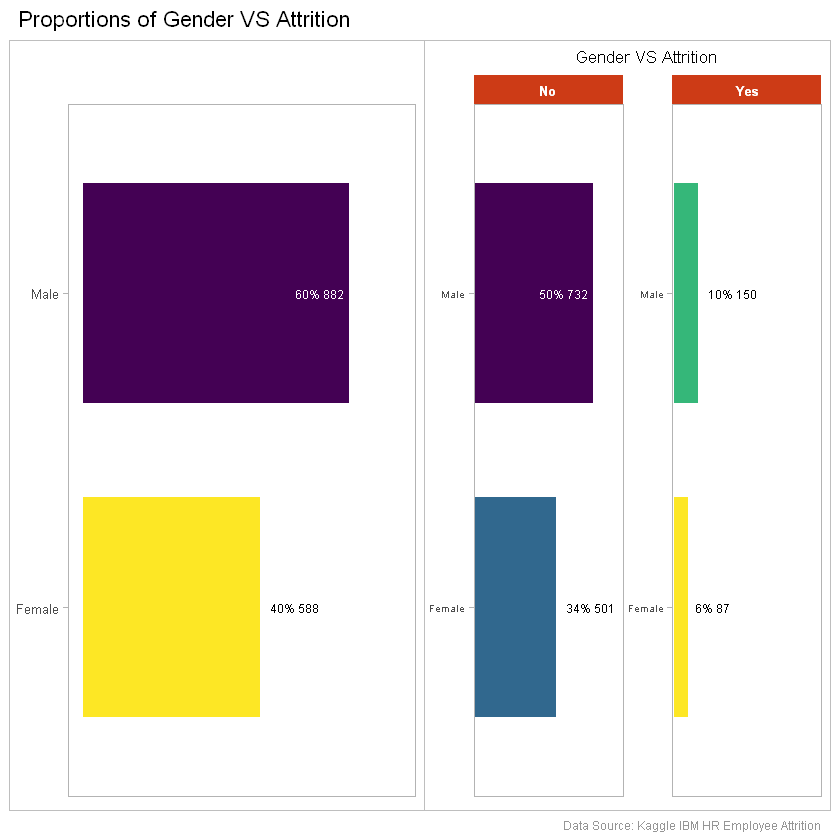

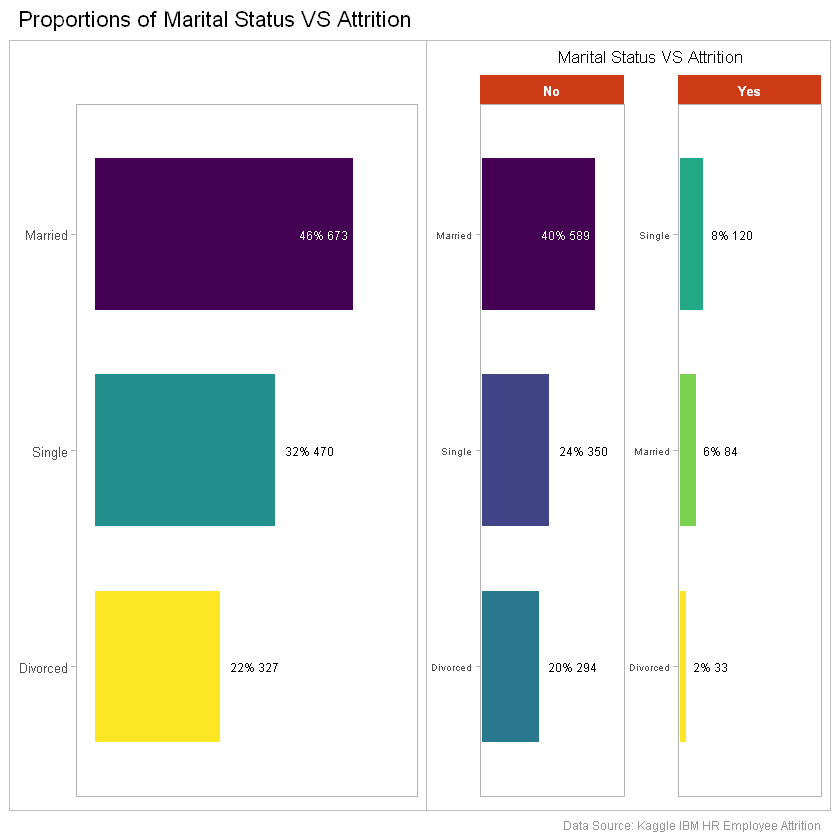

In [11]:
plt_gender <- bar_plot_proportions(gender)
plt_gender_att <- bar_plot_proportions(gender, attrition)
plt_marital_status <- bar_plot_proportions(marital_status)
plt_marital_status_att <- bar_plot_proportions(marital_status, attrition) 


(plt_gender +
   plt_gender_att)+ 
  plot_annotation(
  title = "Proportions of Gender VS Attrition",
  caption = "Data Source: Kaggle IBM HR Employee Attrition"
) & 
  theme(plot.caption = element_text(color = "#969696", size = 7))




   (plt_marital_status +
   plt_marital_status_att ) + 
  plot_annotation(
  title = "Proportions of Marital Status VS Attrition",
  caption = "Data Source: Kaggle IBM HR Employee Attrition"
) & 
  theme(plot.caption = element_text(color = "#969696", size = 7))

Note: I've kept the x-axis labels as it is, so to not have misleading interpretations as in this plot and other plots as well.

> e.g., in left plot, bars starts from top by "Married" while the attrition YES starts by "Single"

**Proportions of Gender VS Attrition:**

-   Somehow balanced, 60% Male and 40% Female.

**Proportions of Marital Status VS Attrition:**

-   Single tend to leave the organisation more than married and divorced.

#### Attrition by Business Travel and Departments

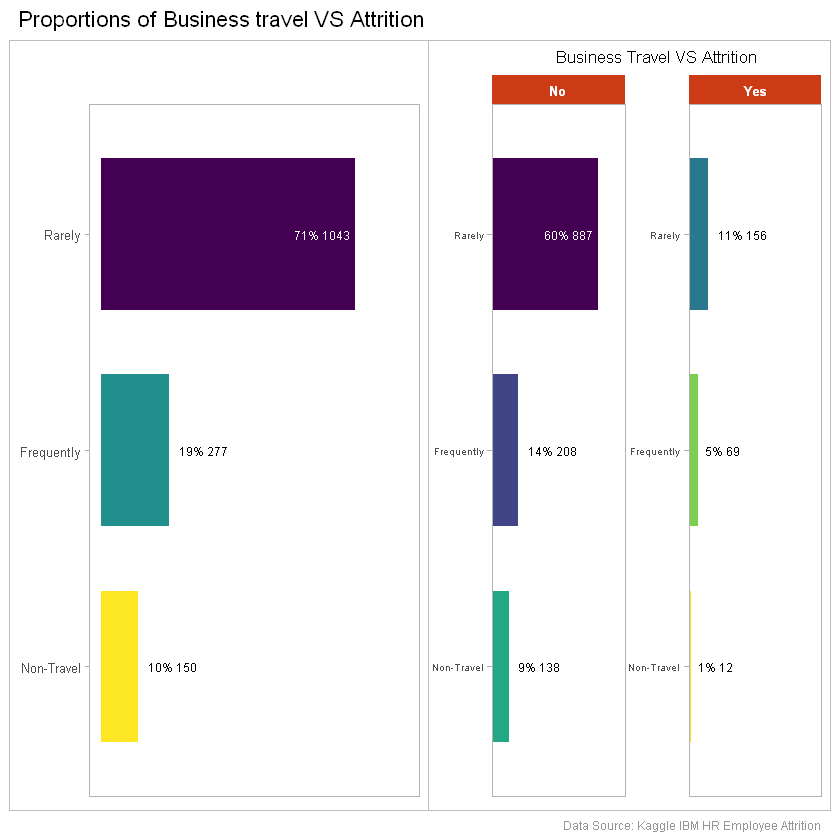

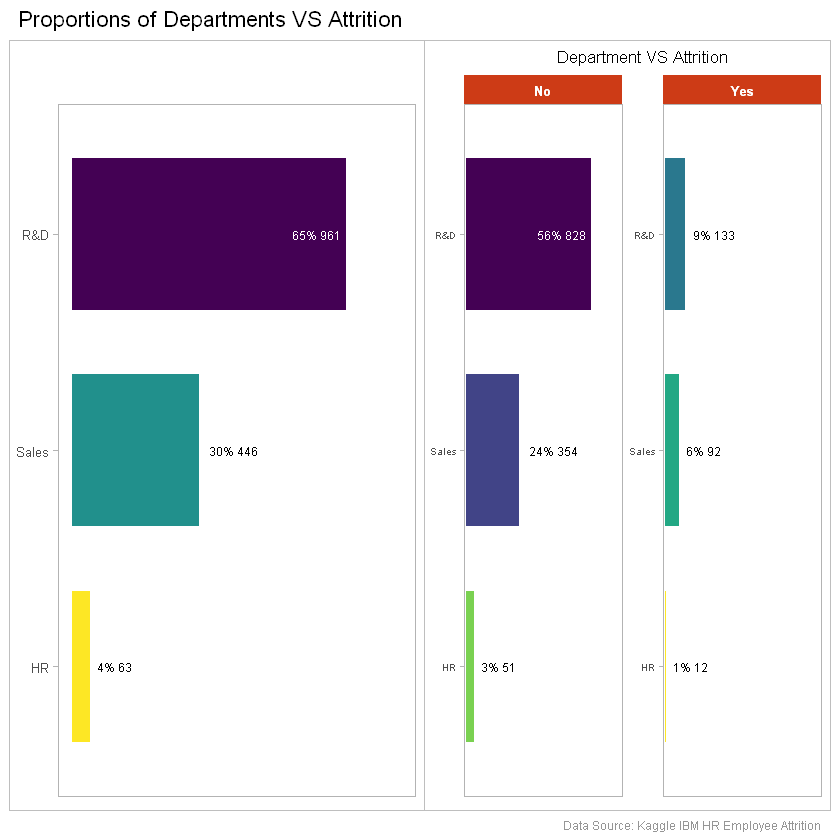

In [12]:
plt_business_travel <- bar_plot_proportions(business_travel)
plt_business_travel_att <- bar_plot_proportions(business_travel, attrition)
plt_department <- bar_plot_proportions(department)
plt_department_att <- bar_plot_proportions(department, attrition) 


(plt_business_travel + 
   plt_business_travel_att ) + 
  plot_annotation(
  title = "Proportions of Business travel VS Attrition",
  caption = "Data Source: Kaggle IBM HR Employee Attrition"
) & 
  theme(plot.caption = element_text(color = "#969696", size = 7))




   (plt_department + 
   plt_department_att) + 
  plot_annotation(
  title = "Proportions of Departments VS Attrition",
  caption = "Data Source: Kaggle IBM HR Employee Attrition"
) & 
  theme(plot.caption = element_text(color = "#969696", size = 7))

**Proportions of Business travel VS Attrition:**

-   Who travel rarely tend to leave the organisation more than who travel Frequently and who do not travel.

**Proportions of Departments VS Attrition:**

-   R&D staff tend to leave the organization more than Sales Team and HR Team.

-   Although the HR Team are less in proportions, i thing 1% and 12 out of 63 employees are high, knowing that the HR team and leaders have an essential role in avoiding and managing the turnover problem.

#### Attrition by Job role Travel and Education field

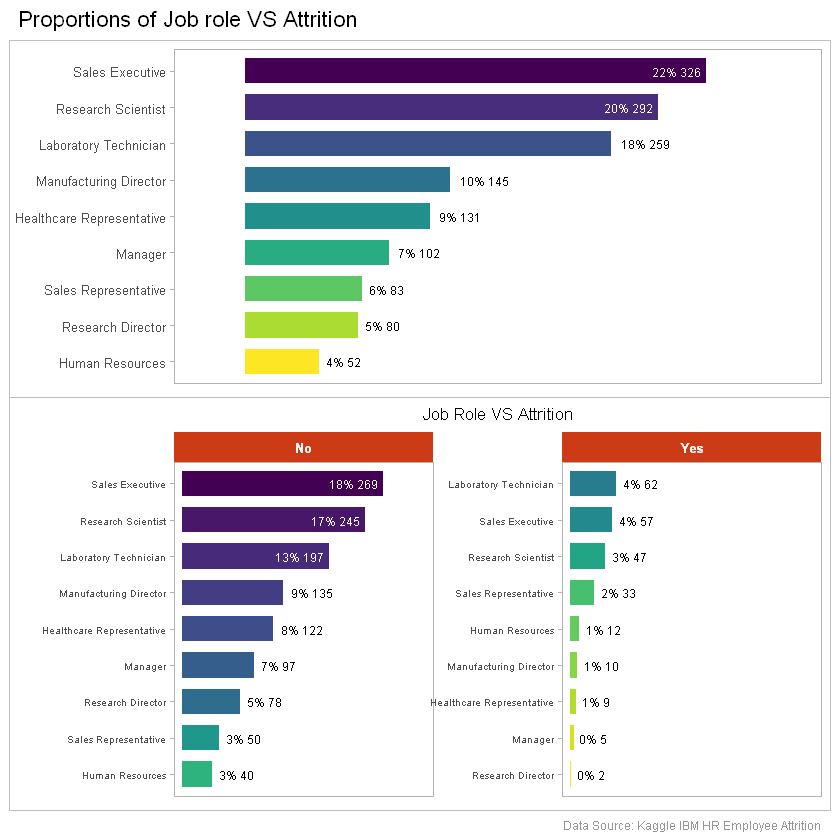

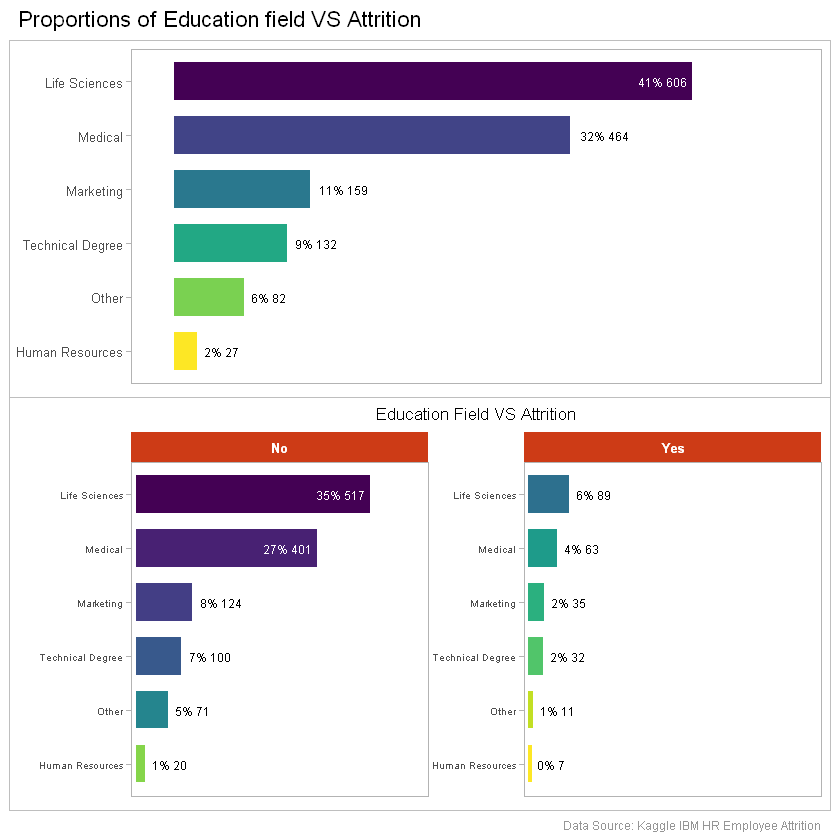

In [13]:
plt_job_role <- bar_plot_proportions(job_role)
plt_job_role_att <- bar_plot_proportions(job_role, attrition) 
plt_education_field <- bar_plot_proportions(education_field)
plt_education_field_att <- bar_plot_proportions(education_field, attrition) 

(plt_job_role /
   plt_job_role_att) + 
  plot_annotation(
  title = "Proportions of Job role VS Attrition",
  caption = "Data Source: Kaggle IBM HR Employee Attrition"
) & 
  theme(plot.caption = element_text(color = "#969696", size = 7))


   (plt_education_field /
   plt_education_field_att) + 
  plot_annotation(
  title = "Proportions of Education field VS Attrition",
  caption = "Data Source: Kaggle IBM HR Employee Attrition"
) & 
  theme(plot.caption = element_text(color = "#969696", size = 7))

**Proportions of Job role VS Attrition:**

-   Laboratory Technician, Sales Executive, Research Scientist and Sales Representative, tend to leave the organisation more than others

**Proportions of Education field VS Attrition:**

-   Life Sciences and Medical tend to leave the organization more than others.

### Monthly Income

#### Monthly Income Distributions

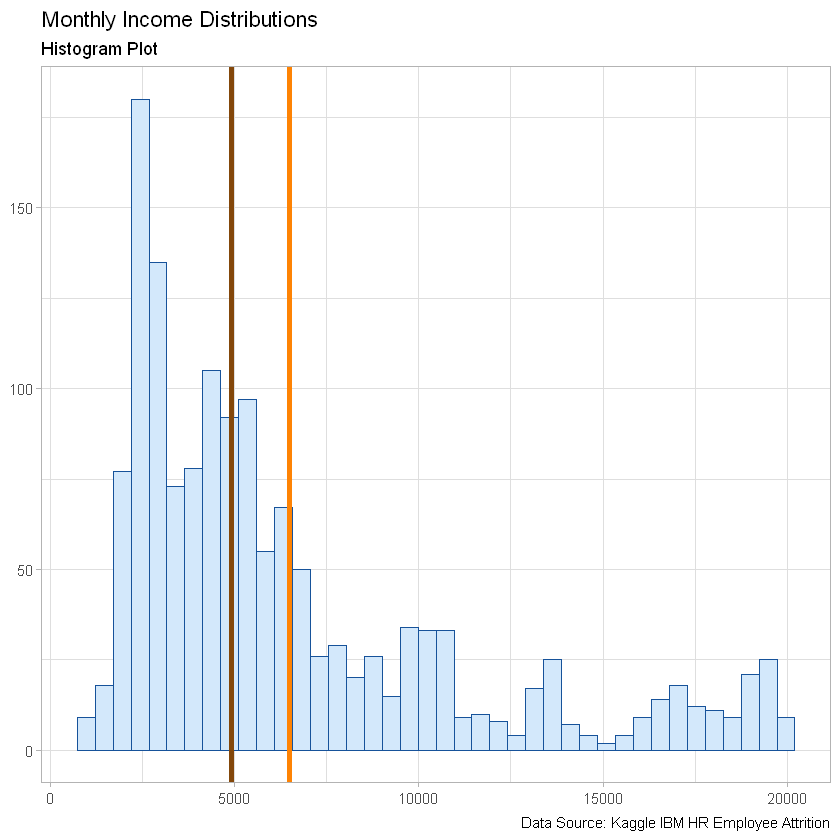

In [14]:
monthly_income_dist <- myData %>% select(monthly_income,) %>% 
  ggplot(aes( x = monthly_income)) +
  geom_histogram(color = "#16529A", fill = "#D3E8FB", bins = 40) +
  geom_vline(aes(xintercept = mean(monthly_income)), color = "#FE8304", size = 1.5) +
   geom_vline(aes(xintercept = median(monthly_income)), color = "#83470A", size = 1.5) +
  labs(
    title = "Monthly Income Distributions",
    subtitle = "Histogram Plot",
    caption = "Data Source: Kaggle IBM HR Employee Attrition",
    x = NULL,
    y = NULL
  )
monthly_income_dist

mean_mi <- round(mean(myData$monthly_income),2)
median_mi <- round(median(myData$monthly_income),2)


- Monthly Income is positively skewed.

- The mean is **`r mean_mi`** and the median is **`r median_mi`**.

- Most of employees are paid below the mean and the median of Monthly Income, that is normal in the most of organizations. 

#### Monthly Income by Gender

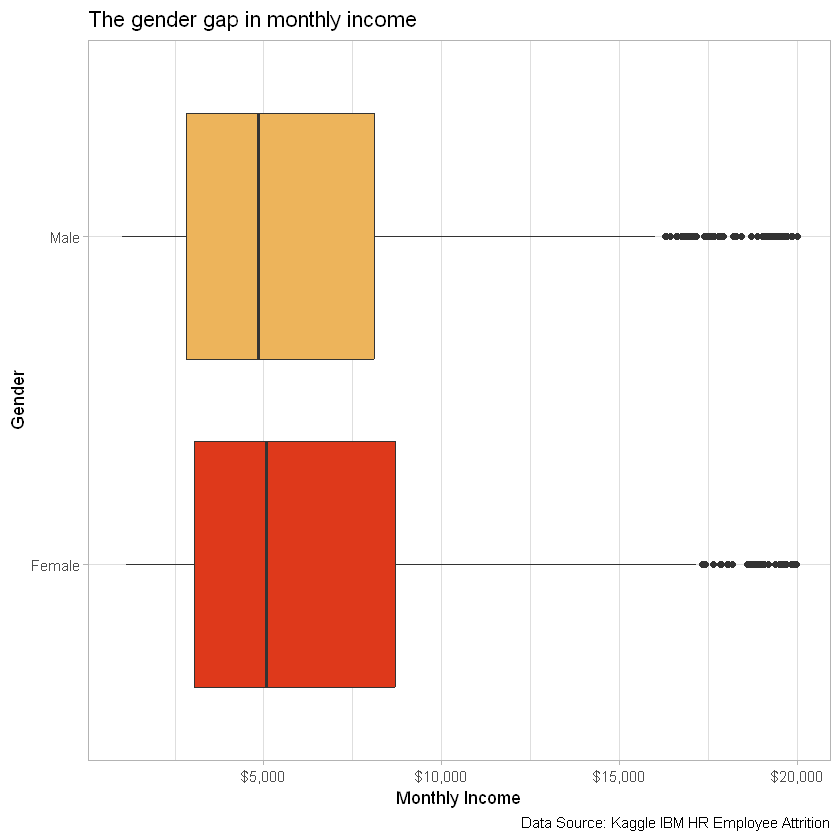

In [15]:
ggplot(myData,
       aes(x = gender,
           y = monthly_income,
           fill = gender)) +
  geom_boxplot(show.legend = FALSE) +
  scale_fill_manual(values = c("#DE391B", "#EDB45B")) +
  coord_flip() +
   scale_y_continuous(labels = label_dollar()) +
  labs(title = "The gender gap in monthly income",
       caption = "Data Source: Kaggle IBM HR Employee Attrition",
       x = "Gender",
       y = "Monthly Income")

Although the Median is noticeably close, the Outliers in the Male are relatively more than Female.

#### Monthly by Gender

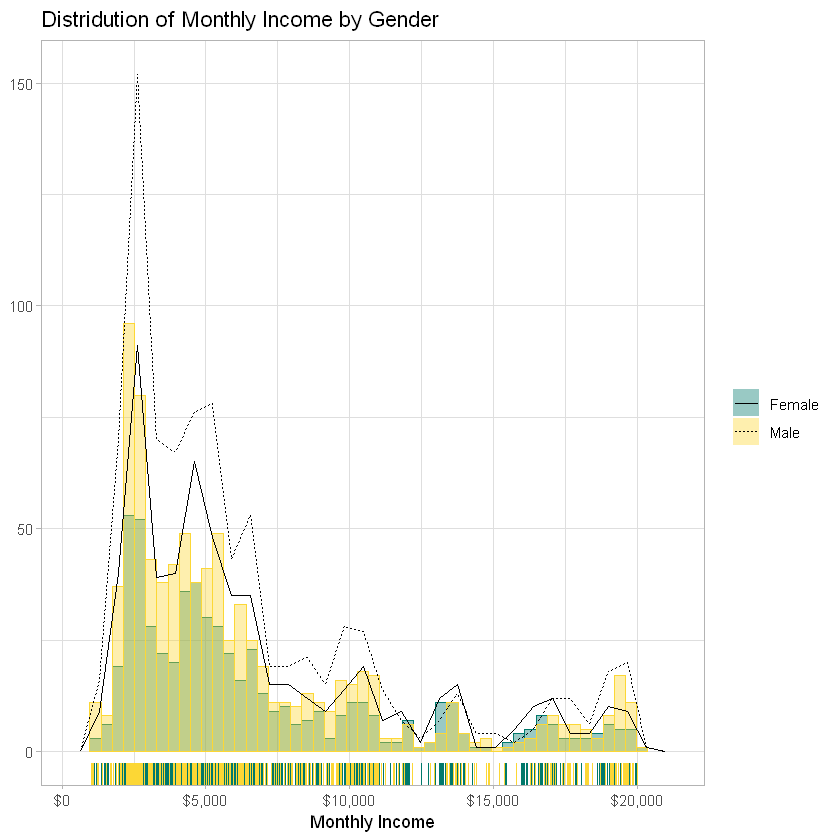

In [16]:
myData %>% select(monthly_income, gender) %>%
  ggplot(aes(monthly_income)) +
  geom_histogram(
    aes(monthly_income, color = gender, fill = gender),
    alpha = 0.4,
    position = "identity",
    bins = 50,
  ) +
  geom_freqpoly(aes(linetype = gender), bins = 30) +
  geom_rug(aes(color = gender)) +
  scale_fill_manual(values = c("#00796B", "#FCD735")) +
  scale_color_manual(values = c("#00796B", "#FCD735")) +
  scale_x_continuous(labels = label_dollar()) +
  guides(color = "none") +
  labs(title = "Distridution of Monthly Income by Gender",
       x = "Monthly Income",
       y = NULL,
       fill = NULL,
       linetype = NULL)

- It is acceptable, especially if we know that the number of Male are More than the number of Female.
 
- We can see that the Outleirs are somehow proportionally shared between Male and Female, ~15,000 is somehow an exception!
 
#### Average Income by Gender and Number of Employees by Department

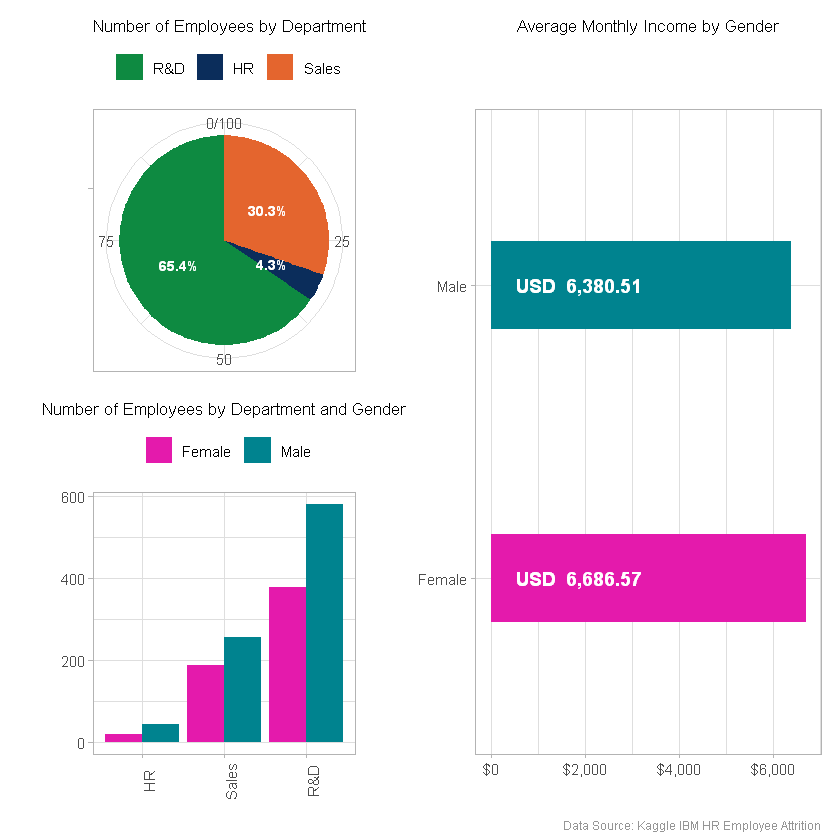

In [17]:
income_by_gender_plt <-
  myData %>% 
  select(gender, monthly_income) %>%
  group_by(gender) %>%
  summarise(avg_income = round(mean(monthly_income), 2), .groups = "drop") %>%
  ggplot(aes(x = gender, y = avg_income)) +
  geom_col(aes(fill = gender), width = 0.3, show.legend = FALSE) +
  geom_text(
    aes(
      x = gender,
      y = 0.01,
      label = dollar(avg_income, prefix = "USD  ")
    ),
    hjust = -0.2,
    size = 4,
    colour = "white",
    fontface = "bold"
  ) +
  coord_flip() +
  scale_y_continuous(labels = label_dollar()) +
  scale_fill_manual(values = c("#E41AAC", "#00838F")) +
  theme(plot.title = element_text(size = 14, hjust = 0.5)) +
  labs(title = "Average Monthly Income by Gender",
       x = NULL,
       y = NULL)



gender_by_department_plt <- 
  myData %>%
  group_by(department, gender) %>% 
  summarise(amount = n(), .groups = "drop") %>%
  ggplot(aes(
    x = fct_reorder(department, amount),
    y = amount,
    fill = gender
  )) + 
  geom_col(position = "dodge") +
  theme(axis.text.x = element_text(angle = 90),
        plot.title = element_text(hjust = 0.5),
        legend.position = "top") + 
  scale_fill_manual(values = c("#E41AAC", "#00838F")) +
  labs(title = "Number of Employees by Department and Gender",
x = NULL,
y = NULL,
fill = NULL)


employees_departments_plt <- 
  myData %>% 
  group_by(department) %>% 
  summarise(amount = n()) %>%
  mutate(prop = round(amount / sum(amount) * 100, 1),
         ypos = cumsum(prop)- 0.5*prop ) %>%
  ggplot(aes(x = "", y = prop, fill = department)) +
  geom_col() +
  coord_polar("y", start = 0) +
  
  geom_text(
    aes(y = prop, label = str_c(prop, "%", sep = "")),
    position = position_stack(vjust = 0.5),
    size = 3,
    col = "white",
    fontface = "bold"
  ) +
  scale_fill_manual (values = c("#0E8A41", "#0B2D5B", "#E4652E")) +
  theme(legend.position = "top")+
  labs(
    title = "Number of Employees by Department",
    fill = NULL,
    x = NULL,
    y = NULL
  )



(( employees_departments_plt / gender_by_department_plt ) | income_by_gender_plt ) +
  plot_annotation(
    caption = "Data Source: Kaggle IBM HR Employee Attrition"
  ) &
  theme(plot.caption = element_text(color = "#969696", size = 7),
        plot.title = element_text(size = 10))

We can see here that the Average Monthly income is almost the same for Male and Female, although I prefer to change the terms Male and Female to Men and Women. 

#### Monthly income by Age:

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


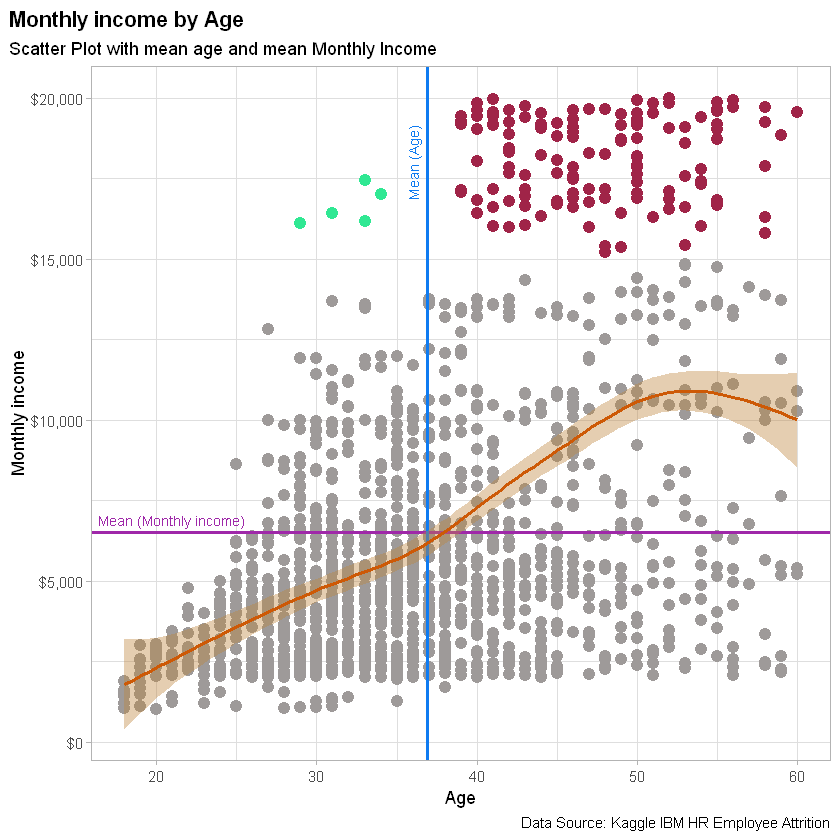

In [18]:
myData %>% select(age, monthly_income) %>%
  mutate(point_color = case_when(monthly_income > 15000 &
                                 age < 35 ~ "1st_col",
                                 monthly_income > 15000 &
                                 age > 35 ~ "2nd_col",
                                 TRUE ~ "3rd_col"
  )) %>% 
  ggplot(aes(x = age, y = monthly_income)) +
  geom_point(aes(color = point_color), size = 3, show.legend = FALSE) +
  geom_hline(aes(yintercept = mean(monthly_income)), color = "#9F28A9", size = 1) +
  geom_vline(aes(xintercept = mean(age)), color = "#0E7BF1", size = 1) +
  geom_smooth(color = "#CD5906", fill = "#BD853D") +
  scale_y_continuous(labels = label_dollar()) +
  scale_color_manual(values = c("1st_col" = "#30E893", "2nd_col" = "#A02448", "3rd_col" = "#9E9A99")) +
  annotate(
    geom = "text",
    x = 36,
    y = 18000,
    label = "Mean (Age)",
    size = 3,
    angle = 90,
    color = "#0E7BF1"
  ) +
  annotate(
    geom = "text",
    x = 21,
    y = 6900,
    label = "Mean (Monthly income)",
    size = 3,
    color = "#9F28A9"
  ) +
theme(
  plot.title.position = "plot",
  plot.title = element_text(
    hjust = 0,
    face = "bold",
    size = 13,
    color = "#000000"
  )
) +
  labs(
    title = "Monthly income by Age",
    subtitle = "Scatter Plot with mean age and mean Monthly Income",
    caption = "Data Source: Kaggle IBM HR Employee Attrition",
    x = "Age",
    y = "Monthly income"
  )

- Five data points are clustered below the mean age and above 15,000 
- Another cluster above the mean age and above 15,000
- The majority of employees are below 10,000 and below 45 years old

The distributions, in my opinion, is practically normal.

#### Monthly income by Total working years:

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


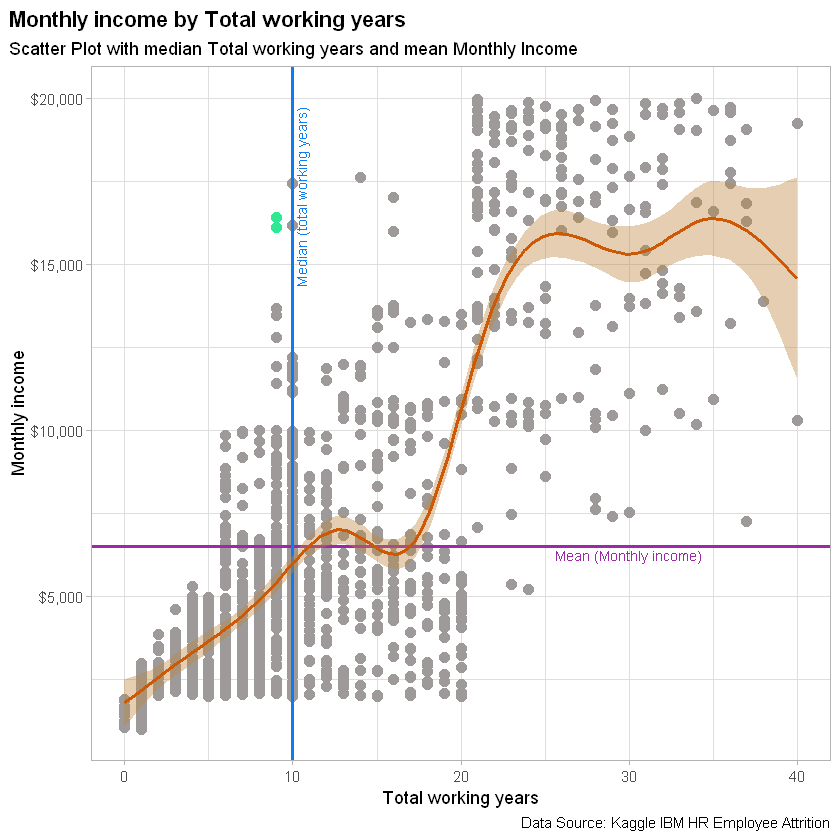

In [19]:
myData %>% select(total_working_years, monthly_income) %>%
  mutate(point_color = case_when(monthly_income > 15000 &
                                 total_working_years < 10 ~ "1st_col",
                                 TRUE ~ "2nd_col"
  )) %>%
  ggplot(aes(x = total_working_years, y = monthly_income)) +
  geom_point(aes(color = point_color), size = 2.7, show.legend = FALSE) +
  geom_hline(aes(yintercept = mean(monthly_income)), color = "#9F28A9", size = 1) +
  geom_vline(aes(xintercept = median(total_working_years)), color = "#0E7BF1", size = 1) +
  geom_smooth(color = "#CD5906", fill = "#BD853D") +
  scale_y_continuous(labels = label_dollar()) +
  scale_color_manual(values = c( "1st_col" = "#30E893", "2nd_col" = "#9E9A99")) +
  annotate(
    geom = "text",
    x = 10.5,
    y = 17000,
    label = "Median (total working years)",
    size = 3,
    angle = 90,
    color = "#0E7BF1"
  ) +
  annotate(
    geom = "text",
    x = 30,
    y = 6260,
    label = "Mean (Monthly income)",
    size = 3,
    color = "#9F28A9"
  ) +
theme(
  plot.title.position = "plot",
  plot.title = element_text(
    hjust = 0,
    face = "bold",
    size = 13,
    color = "#000000"
  )
) +
  labs(
    title = "Monthly income by Total working years",
    subtitle = "Scatter Plot with median Total working years and mean Monthly Income",
    caption = "Data Source: Kaggle IBM HR Employee Attrition",
    x = "Total working years",
    y = "Monthly income"
  )

- Two data points are clustered below the median total working years and above 15,000.
- Another 2 data points on the median total working years and above 15,000
- It is very practical figure that the Monthly Income increases when the Total working years increases.

#### Attrition by Monthly Income and Age

In [20]:
myData %>% select(age, monthly_income, attrition) %>%
  ggplot(aes(age, monthly_income, color = monthly_income)) +
  geom_point() +
  geom_smooth(method = "lm") +
  facet_wrap(vars(attrition)) +
  scale_y_continuous(labels = label_dollar()) +
  scale_color_viridis_c(labels = label_dollar()) +
  theme(strip.background = element_rect(fill = "#B66611"),
        strip.text = element_text(color = "white", face = "bold", size = 8)) +
  labs(title = "Monthly Income by Age and Attrition",
       x = NULL,
       y = NULL,
       color = NULL)

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"The following aesthetics were dropped during statistical transformation: colour
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?"
Warning message:
"The following aesthetics were dropped during statistical transformation: colour
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?"


- Those how have low monthly income tend to leave the organization. 
- Five data points above 20,000 and above 40 years old , attrition YES

#### Monthly income by Age, Departemnts

Warning message:
"`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information."


Warning message:
"The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


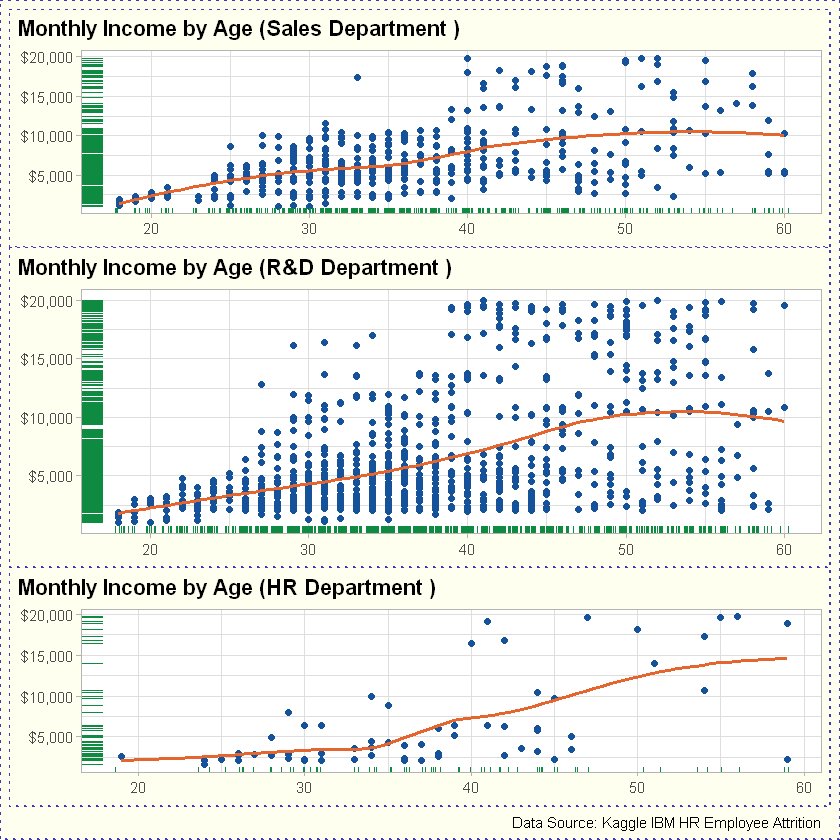

In [ ]:
age_sales_mi <- across_features_num_x_plot(x_var = "age",
                                           section = "department",
                                           subsection = "Sales",
                                           y_var = "monthly_income") + 
                geom_smooth(color = "#E4652E", se = F) + 
                scale_y_continuous(label = dollar)


age_RD_mi <- across_features_num_x_plot(x_var = "age", 
                                        section = "department",
                                        subsection = "R&D",
                                        y_var = "monthly_income") + 
             geom_smooth(color = "#E4652E", se = F) +
             scale_y_continuous(label = dollar)


age_HR_mi <- across_features_num_x_plot(x_var = "age", 
                                        section = "department",
                                        subsection = "HR",
                                        y_var = "monthly_income") + 
             geom_smooth(color = "#E4652E", se = F) + 
             scale_y_continuous(label = dollar) 


(age_sales_mi / age_RD_mi / age_HR_mi) + 
  plot_annotation(
    caption = "Data Source: Kaggle IBM HR Employee Attrition"
  ) +
  plot_layout(height = c(1, 1.5, 1)) &
  theme(plot.background = element_rect(
    color  = "#3F39B7",
    size = 0.8,
    linetype = "dotted",
    fill = "ivory"
  ))

- R&D Department has the highest number of employees then Sales Department and HR is the lowest Number, that is reasonably Normal
- Proportionally, R&D has the highest number of employees who have the highest Salary, then Sales and HR.

#### Monthly income by business travel and Departments

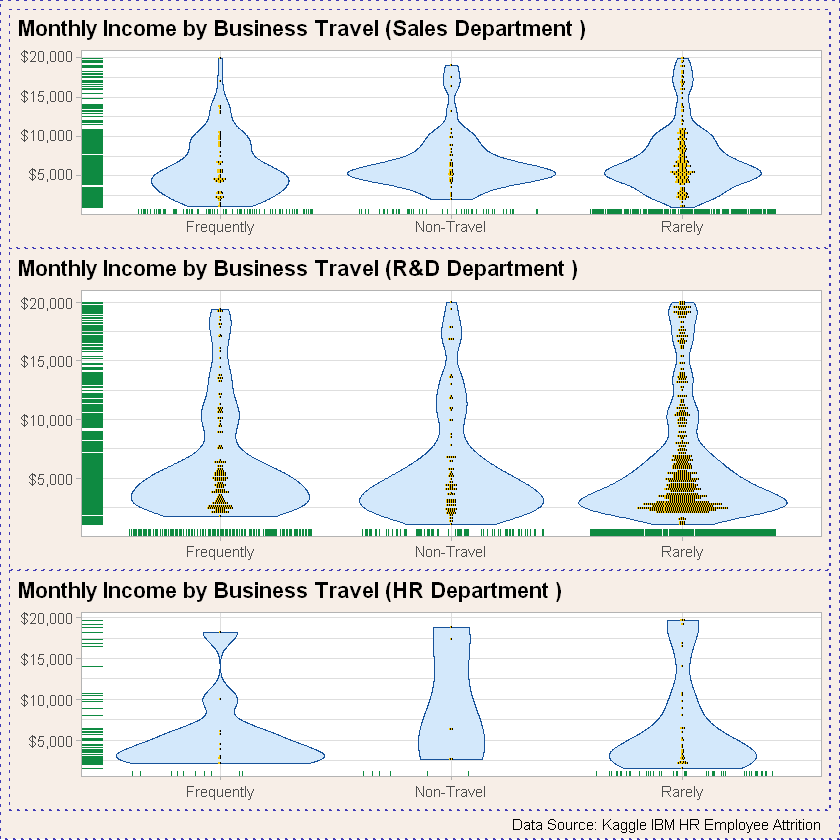

In [ ]:
bt_sales_mi <- across_features_fact_x_plot(x_var = "business_travel",
                                           section = "department",
                                           subsection = "Sales",
                                           y_var = "monthly_income") + 
                scale_y_continuous(label = dollar)


bt_RD_mi <- across_features_fact_x_plot(x_var = "business_travel", 
                                        section = "department",
                                        subsection = "R&D",
                                        y_var = "monthly_income") +
             scale_y_continuous(label = dollar)


bt_HR_mi <- across_features_fact_x_plot(x_var = "business_travel", 
                                        section = "department",
                                        subsection = "HR",
                                        y_var = "monthly_income") + 
             scale_y_continuous(label = dollar) 


(bt_sales_mi / bt_RD_mi / bt_HR_mi) + 
  plot_annotation(
    caption = "Data Source: Kaggle IBM HR Employee Attrition"
  ) +
  plot_layout(height = c(1, 1.5, 1)) &
  theme(plot.background = element_rect(
    color  = "#3F39B7",
    size = 0.8,
    linetype = "dotted",
    fill = "#F7EEE7"
  ))

- R&D and Sales: Employees below 5,000 in monthly income tend to travel frequently more than others, although R&D has the majority of employees

#### Monthly income by Gender and Business travel

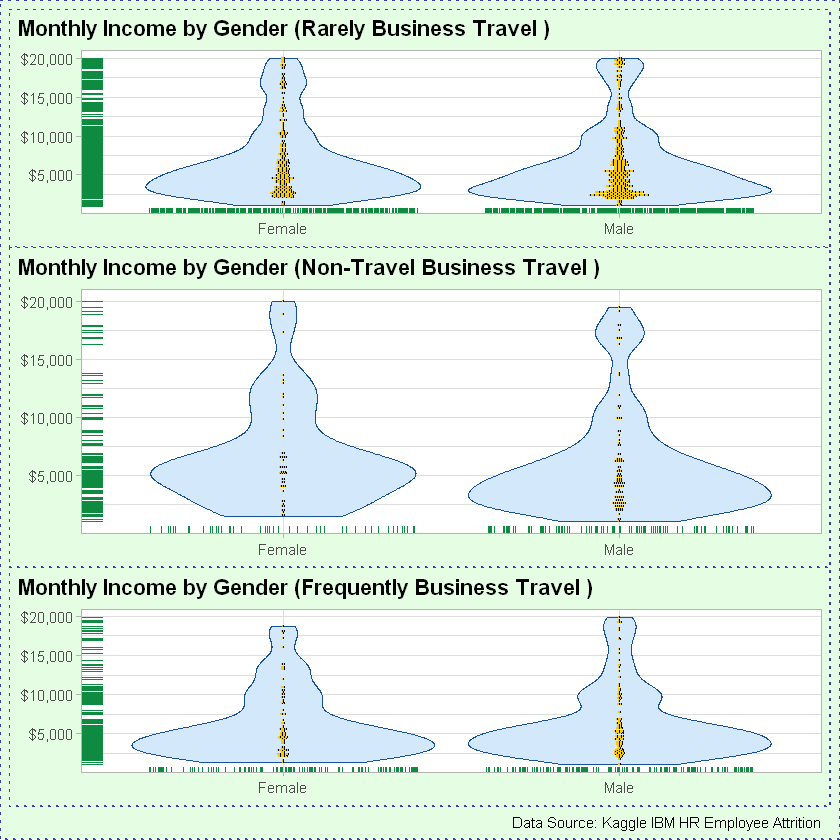

In [ ]:
gen_Frequently_mi <- across_features_fact_x_plot(x_var = "gender",
                                           section = "business_travel",
                                           subsection = "Frequently",
                                           y_var = "monthly_income") + 
                scale_y_continuous(label = dollar)


gen_Rarely_mi <- across_features_fact_x_plot(x_var = "gender", 
                                        section = "business_travel",
                                        subsection = "Rarely",
                                        y_var = "monthly_income") +
             scale_y_continuous(label = dollar)


gen_Non_Travel_mi <- across_features_fact_x_plot(x_var = "gender", 
                                        section = "business_travel",
                                        subsection = "Non-Travel",
                                        y_var = "monthly_income") + 
             scale_y_continuous(label = dollar) 



(gen_Rarely_mi / gen_Non_Travel_mi / gen_Frequently_mi) + 
  plot_annotation(
    caption = "Data Source: Kaggle IBM HR Employee Attrition"
  ) +
  plot_layout(height = c(1, 1.5, 1)) &
  theme(plot.background = element_rect(
    color  = "#3F39B7",
    size = 0.8,
    linetype = "dotted",
    fill = "#E5FDE3"
  ))

- It is clear that there is no big difference between Women and Men in terms of Business travel categories

#### Monthly income by Gender and Education field

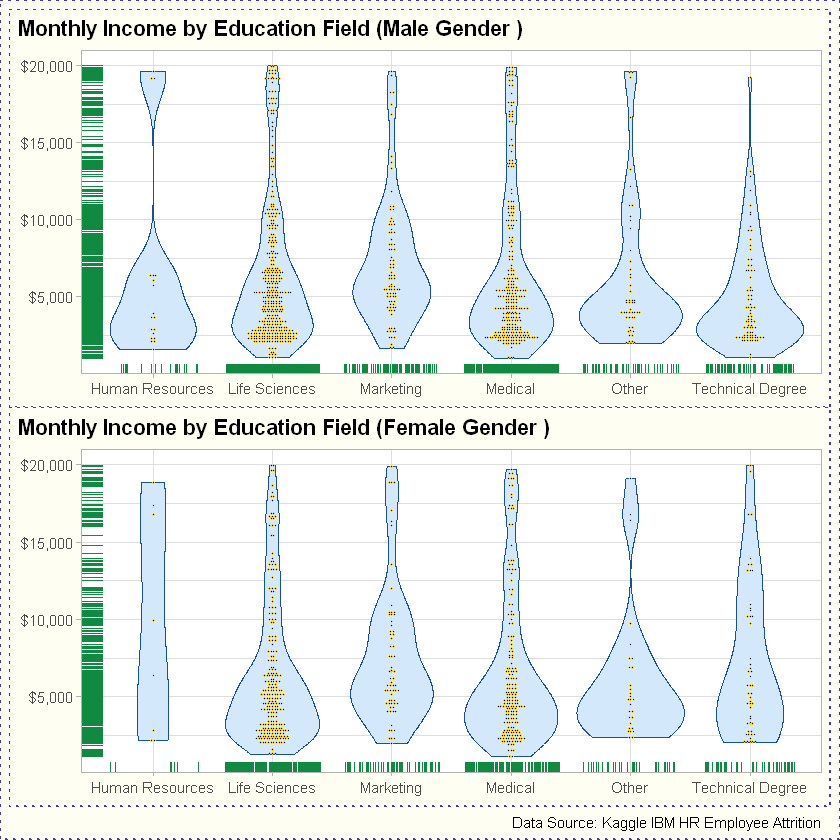

In [ ]:
edu_male_mi <- across_features_fact_x_plot(x_var = "education_field",
                                           section = "gender",
                                           subsection = "Male",
                                           y_var = "monthly_income") + 
                scale_y_continuous(label = dollar)


edu_female_mi <- across_features_fact_x_plot(x_var = "education_field", 
                                        section = "gender",
                                        subsection = "Female",
                                        y_var = "monthly_income") +
             scale_y_continuous(label = dollar)



(edu_male_mi / edu_female_mi) + 
  plot_annotation(
    caption = "Data Source: Kaggle IBM HR Employee Attrition"
  ) +
  plot_layout(height = c(1,1)) &
  theme(plot.background = element_rect(
    color  = "#3F39B7",
    size = 0.8,
    linetype = "dotted",
    fill = "#FEFFF2"
  ))

- According to many plots for Gender, and age and now Education field, the Gender and Age are non important variables to among many others like Education field, business travel.

No we are going to check the Over-Time variable, 



### Over Time

Reasons for Using Overtime

There are many reasons for the organisation using overtime:

- 24/7 coverage.
- Workload fluctuations.
- Staff variations.

There are 4 common reasons employees work Over-Time.

- I want to impress my boss syndrome

- Overtime Pay

- Mandatory overtime 

- Workload 

#### Monthly Income distribution by Over-Time

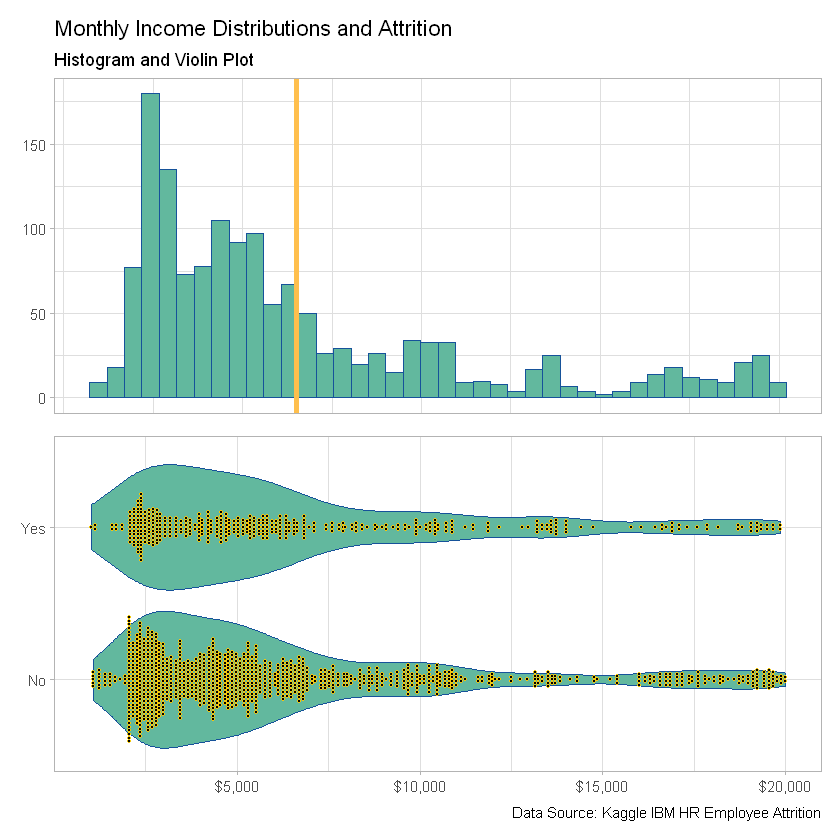

In [ ]:
monthly_income_dist <- myData %>% select(monthly_income, ) %>%
  ggplot(aes(x = monthly_income)) +
  geom_histogram(color = "#16529A", fill = "#62B89E", bins = 40) +
  geom_vline(aes(xintercept = mean(monthly_income)), color = "#FFBF4D", size = 1.5) +
  theme(axis.text.x = element_blank(),
        axis.ticks.x = element_blank()
        )+
  labs(
    title = "Monthly Income Distributions and Attrition",
    subtitle = "Histogram and Violin Plot",
    x = NULL,
    y = NULL
  )



mi_over_time <-
  myData %>% select(monthly_income, over_time) %>%
  ggplot(aes(x = over_time, y = monthly_income)) +
  geom_violin(color = "#16529A", fill = "#62B89E") +
  geom_dotplot(
    binaxis = "y",
    binwidth = 100,
    stackdir = "center",
    color = "#F3C80D"
  ) +
  coord_flip() +
  scale_y_continuous(labels = label_dollar()) +
   labs(
    title = NULL,
    subtitle = NULL,
    caption = "Data Source: Kaggle IBM HR Employee Attrition",
    x = NULL,
    y = NULL
  )


monthly_income_dist / mi_over_time

- The majority of Employees who take Over-time are those who are below the mean of Monthly Income

Practically Normal

#### Over-time distributions by Education feild and Attrition

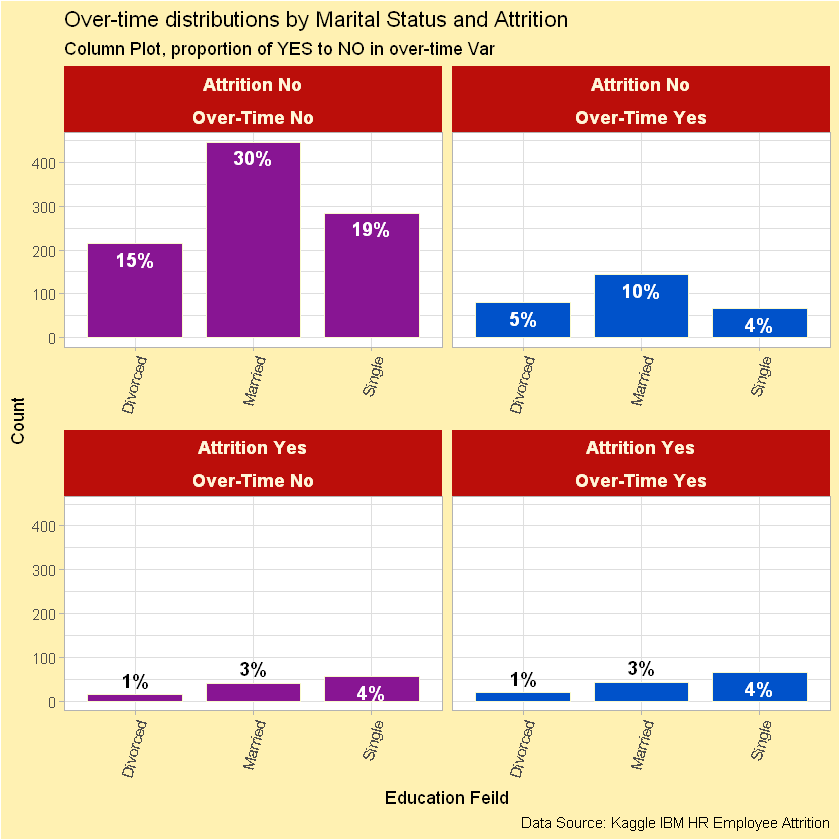

In [ ]:
over_att_marital_status <- myData %>% select(over_time, attrition, marital_status) %>%
  group_by(over_time, attrition, marital_status) %>%
  summarise(count = n(), .groups = "drop") %>%
  mutate(prop = str_c(round(count / sum(count) * 100, 0), "%"),
         label_vjust = case_when(
                  count < quantile(count, probs = 0.3) ~ -0.5,
                  TRUE ~ 1.5,
                ), 
         label_color = case_when(
                  count < quantile(count, probs = 0.3) ~ "black",
                  TRUE ~ "white",
                ))


ggplot(over_att_marital_status, aes(x = marital_status, y = count, fill = over_time)) +
  geom_col(width = 0.8,
           color = "#FAFACD"
           ) +
  geom_text(show.legend = FALSE,
    aes(label = prop, 
        vjust = label_vjust,
        color = label_color),
    size = 4,
    fontface = "bold"
  ) +
  facet_wrap(vars(str_c("Attrition", attrition, sep =  " ") ,
                  str_c("Over-Time", over_time, sep = " ")),
             scales = "free_x") +
  scale_fill_manual (values = c("#881593", "#0052CA")) +
  scale_color_manual (values = c("black", "white"))+
   theme(
        legend.position = "none",
        strip.background = element_rect(fill = "#BB0E0A"),
        strip.text = element_text(color = "#FFF6D8", face = "bold", size = 11),
        axis.text.x = element_text(angle = 75, hjust = 1),
        plot.background = element_rect(fill = "#FFF1B2")) +
  labs(
    title = "Over-time distributions by Marital Status and Attrition",
    subtitle = "Column Plot, proportion of YES to NO in over-time Var",
    caption = "Data Source: Kaggle IBM HR Employee Attrition",
    x= "Education Feild",
    y = "Count",
    
  )

- Really one of the main challenges in interpreting those plots is the imbalanced class variable (label), this will be a chalange during building a model. 

- Married people tend to take overtime more than others, however, Single people tend to leave the organization more than others.


#### Over-time distributions by Gender and Attrition

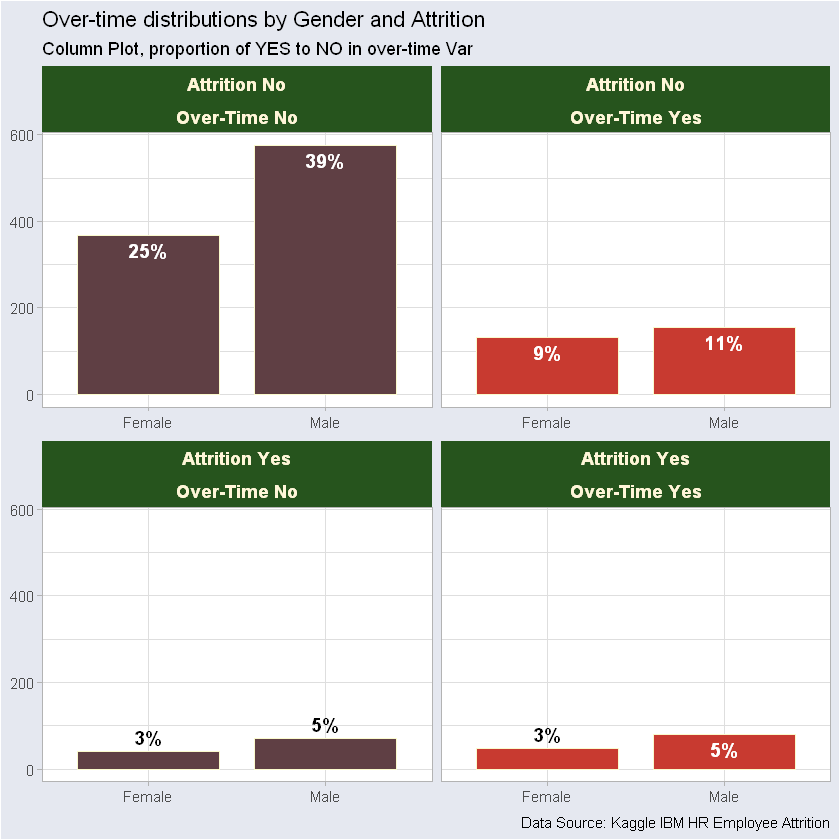

In [ ]:
over_att_gender <- myData %>% select(over_time, attrition, gender) %>%
  group_by(over_time, attrition, gender) %>%
  summarise(count = n(), .groups = "drop") %>%
  mutate(prop = str_c(round(count / sum(count) * 100, 0), "%"),
         label_vjust = case_when(
                  count < quantile(count, probs = 0.4) ~ -0.5,
                  TRUE ~ 1.5,
                ), 
         label_color = case_when(
                  count < quantile(count, probs = 0.4) ~ "black",
                  TRUE ~ "white",
                ))


ggplot(over_att_gender, aes(x = gender, y = count, fill = over_time)) +
  geom_col(width = 0.8,
           color = "#FAFACD"
           ) +
  geom_text(show.legend = FALSE,
    aes(label = prop, 
        vjust = label_vjust,
        color = label_color),
    size = 4,
    fontface = "bold"
  ) +
  facet_wrap(vars(str_c("Attrition", attrition, sep =  " ") ,
                  str_c("Over-Time", over_time, sep = " ")),
             scales = "free_x") +
  scale_fill_manual (values = c("#5F3F44", "#C83A30")) +
  scale_color_manual (values = c("black", "white"))+
   theme(
        legend.position = "none",
        strip.background = element_rect(fill = "#26541D"),
        strip.text = element_text(color = "#FFF6D8", face = "bold", size = 11),
        axis.text.x = element_text(),
        plot.background = element_rect(fill = "#E5E8F0")) +
  labs(
    title = "Over-time distributions by Gender and Attrition",
    subtitle = "Column Plot, proportion of YES to NO in over-time Var",
    caption = "Data Source: Kaggle IBM HR Employee Attrition",
    x= NULL,
    y = NULL,
    
  )

- Men tend to take overtime more than Women, and Men who take over_time tend to leave the organization more than Women


### Job Satisfaction


#### Attrition by Job Satisfaction

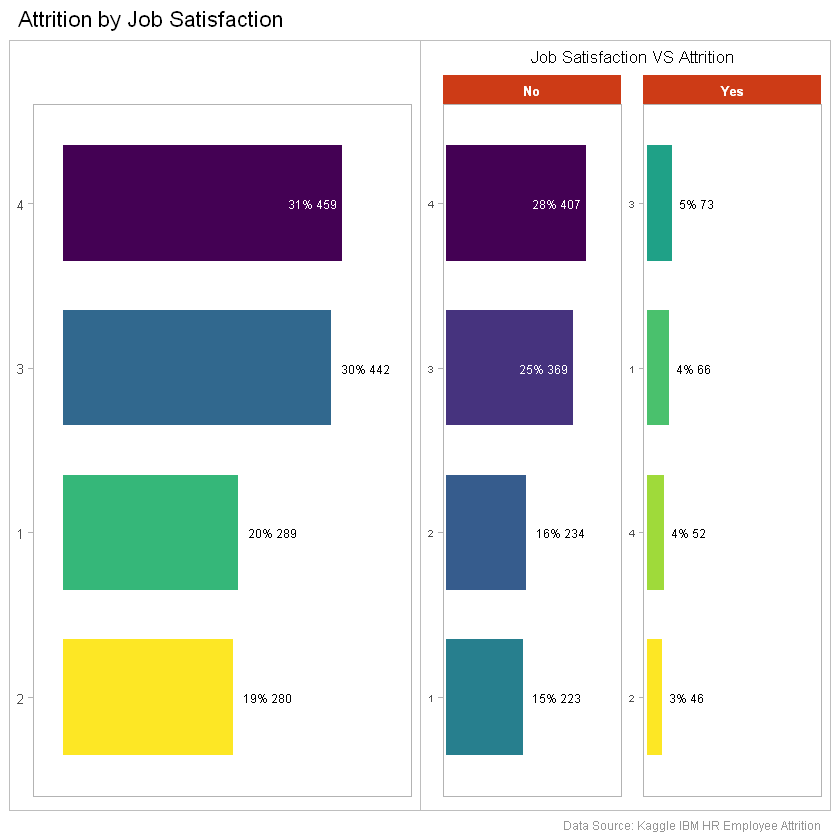

In [ ]:
plt_job_satisfaction <- bar_plot_proportions(job_satisfaction)
plt_job_satisfaction_att <- bar_plot_proportions(job_satisfaction, attrition)

(plt_job_satisfaction +
   plt_job_satisfaction_att)+ 
  plot_annotation(
  title = "Attrition by Job Satisfaction",
  caption = "Data Source: Kaggle IBM HR Employee Attrition"
) & 
  theme(plot.caption = element_text(color = "#969696", size = 7))

#### Job Satisfaction by Gender

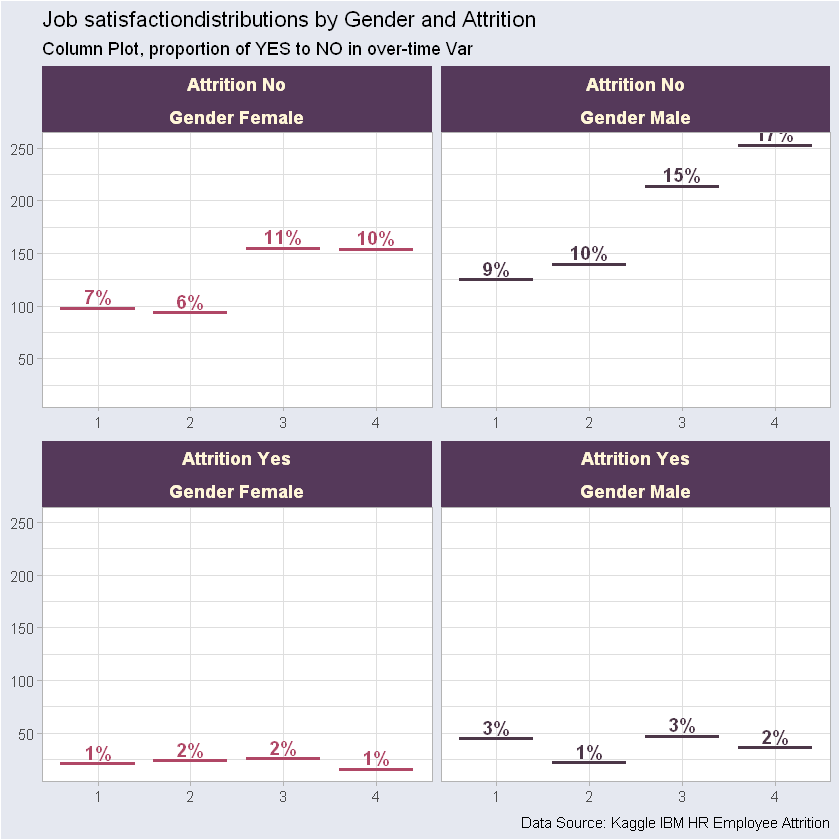

In [ ]:
job_satisfaction_gender <- myData %>% select(job_satisfaction, attrition, gender) %>%
  group_by(job_satisfaction, attrition, gender) %>%
  summarise(count = n(), .groups = "drop") %>%
  mutate(prop = str_c(round(count / sum(count) * 100, 0), "%"),
         )


ggplot(job_satisfaction_gender, aes(x = as.factor(job_satisfaction), y = count, color = gender)) +
  geom_boxplot(aes(color = gender),width = 0.8
           ) +
  geom_text(show.legend = FALSE,
    aes(label = prop
        ),
    vjust = -0.3,
    size = 4,
    fontface = "bold"
  ) +
  facet_wrap(vars(str_c("Attrition", attrition, sep =  " ") ,
                  str_c("Gender", gender, sep = " ")),
             scales = "free_x") +
  scale_color_manual (values = c("#B04766", "#4C3748"))+
   theme(
        legend.position = "none",
        strip.background = element_rect(fill = "#55395A"),
        strip.text = element_text(color = "#FFF6D8", face = "bold", size = 11),
        axis.text.x = element_text(),
        plot.background = element_rect(fill = "#E5E8F0")) +
  labs(
    title = "Job satisfactiondistributions by Gender and Attrition",
    subtitle = "Column Plot, proportion of YES to NO in over-time Var",
    caption = "Data Source: Kaggle IBM HR Employee Attrition",
    x= NULL,
    y = NULL,
    
  )

For people who didn't leave the company: job satisfaction levels are somehow the same but for people who left the company, females had a lower satisfaction level.

We have to put into consideration the proportion of female 40% to male 60%.


## B. Predictive modeling

### Create data for modeling

In [ ]:
# check the levels for Attrition var

levels(myData$attrition)

# reverse the levels

myData <- myData %>% 
  mutate(attrition = factor(attrition, levels = c("Yes", "No")))

levels(myData$attrition)

myData_for_model <-
  myData %>% 
  select(-c(over18, standard_hours, employee_count, employee_number)) %>% 
  mutate(across(
    c(
      education,
      environment_satisfaction,
      job_involvement,
      job_level,
      job_satisfaction,
      performance_rating,
      relationship_satisfaction,
      work_life_balance,
      stock_option_level,
    ),
    factor
  ))

glimpse(myData_for_model)

[1] "No"  "Yes"

[1] "Yes" "No"

Rows: 1,470
Columns: 32
$ age                        <dbl> 41, 49, 37, 33, 27, 32, 59, 30, 38, 36, 35,…
$ attrition                  <fct> Yes, No, Yes, No, No, No, No, No, No, No, N…
$ business_travel            <fct> Rarely, Frequently, Rarely, Frequently, Rar…
$ daily_rate                 <dbl> 1102, 279, 1373, 1392, 591, 1005, 1324, 135…
$ department                 <fct> Sales, R&D, R&D, R&D, R&D, R&D, R&D, R&D, R…
$ distance_from_home         <dbl> 1, 8, 2, 3, 2, 2, 3, 24, 23, 27, 16, 15, 26…
$ education                  <fct> 2, 1, 2, 4, 1, 2, 3, 1, 3, 3, 3, 2, 1, 2, 3…
$ education_field            <fct> Life Sciences, Life Sciences, Other, Life S…
$ environment_satisfaction   <fct> 2, 3, 4, 4, 1, 4, 3, 4, 4, 3, 1, 4, 1, 2, 3…
$ gender                     <fct> Female, Male, Male, Female, Male, Male, Fem…
$ hourly_rate                <dbl> 94, 61, 92, 56, 40, 79, 81, 67, 44, 94, 84,…
$ job_involvement            <fct> 3, 2, 2, 3, 3, 3, 4, 3, 2, 3, 4, 2, 3, 3, 2…
$ job_level     

For a data splitting strategy, let's reserve 25% of the stays to the test set. I know our outcome variable Attrition is pretty imbalanced so I’ll use a stratified random sample.

### Data Split

In [ ]:
set.seed(31967)

myData__data_split <- initial_split(myData_for_model, prop = 3/4, strata = attrition)

train_data <- training(myData__data_split)
test_data  <- testing(myData__data_split)

#### Training and testing set proportions by attrition

In [ ]:
train_data %>% 
  count(attrition) %>% 
  mutate(prop = n/sum(n))


test_data  %>% 
  count(attrition) %>% 
  mutate(prop = n/sum(n))

attrition,n,prop
<fct>,<int>,<dbl>
Yes,177,0.1607629
No,924,0.8392371


attrition,n,prop
<fct>,<int>,<dbl>
Yes,60,0.1626016
No,309,0.8373984


#### Generate bootstrap samples

In [ ]:
set.seed(31967)
boot_strap <- bootstraps(train_data, times = 10, apparent = TRUE)

### First Model: Penalized Logistic Regression

Note: All Functions were explained based on the official website of Tidymodels framework.

Link: https://www.tidymodels.org/


#### Build the model (glmnet)

In [ ]:
logis_mod <- 
  logistic_reg(penalty = tune(), mixture = 1) %>% 
  set_engine("glmnet")

#### Create the recipe (glmnet)

In [ ]:
logis_recipe <-
  recipe(attrition ~ ., data = train_data) %>%
  step_dummy(all_nominal_predictors(), -all_outcomes()) %>%
  step_zv(all_numeric()) %>%
  step_smote(attrition, over_ratio = 0.9, seed = 31967) %>%
  step_normalize(all_numeric())

summary(logis_recipe)

variable,type,role,source
<chr>,<list>,<chr>,<chr>
age,"double , numeric",predictor,original
business_travel,"factor , unordered, nominal",predictor,original
daily_rate,"double , numeric",predictor,original
department,"factor , unordered, nominal",predictor,original
distance_from_home,"double , numeric",predictor,original
education,"factor , unordered, nominal",predictor,original
education_field,"factor , unordered, nominal",predictor,original
environment_satisfaction,"factor , unordered, nominal",predictor,original
gender,"factor , unordered, nominal",predictor,original


- step_dummy(): Convert nominal into one or more numeric binary model terms for the levels of the original data.

- step_zv(): Remove variables that contain only a single value.

- step_smote(): Generate new examples of the minority class using nearest neighbors of these cases.

- step_normalize(): Normalize numeric data to have a standard deviation of one and a mean of zero

- step_corr(): Remove variables that have large absolute correlations with other variables.


#### Create the workflow (glmnet)

In [ ]:
logis_workflow <- 
  workflow() %>% 
  add_model(logis_mod) %>% 
  add_recipe(logis_recipe)

- A workflow is an object that can bundle together your pre-processing, modeling, and post-processing requests.

#### Create the Grid (glmnet)

In [ ]:
logis_reg_grid <- tibble(penalty = 10^seq(-3, -1, length.out = 60))
logis_reg_grid %>% top_n(-5) 

logis_reg_grid %>% top_n(5)

Selecting by penalty


penalty
<dbl>
0.001000000
0.001081181
0.001168952
0.001263848
0.001366448


Selecting by penalty


penalty
<dbl>
0.07318242
0.07912343
0.08554673
0.09249147
0.10000000


#### Train and tune the model (glmnet)

In [ ]:
set.seed(31967)
logis_res <- 
  logis_workflow %>% 
  tune_grid(boot_strap,
            grid = logis_reg_grid,
            control = control_grid(save_pred = TRUE),
            metrics = metric_set(roc_auc))

Warning message:
"package 'glmnet' was built under R version 4.3.1"


- tune_grid(): Computes a set of performance metrics (e.g. accuracy or RMSE) for a pre-defined set of tuning parameters that correspond to a model or recipe across one or more resamples of the data.


#### Plot the area under the ROC VS penalty value (glmnet)

By plotting the area under the ROC curve against the range of penalty values, will be easier to visualize the validation set metrics.

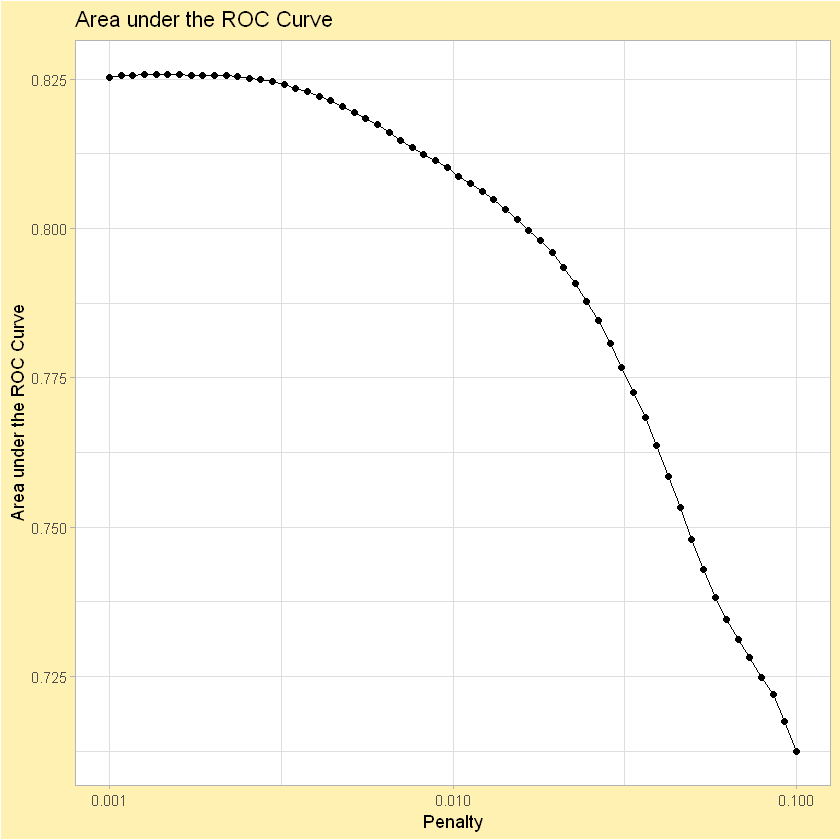

In [ ]:
logis_plot <- 
  logis_res %>% 
  collect_metrics() %>% 
  ggplot(aes(x = penalty, y = mean)) + 
  geom_point() + 
  geom_line() + 
  scale_x_log10(labels = scales::label_number()) +
   theme(
        plot.background = element_rect(fill = "#FFF1B2")) +
  labs(
    title = "Area under the ROC Curve",
    x= "Penalty",
    y = "Area under the ROC Curve"
    
  )

logis_plot

We can see that model performance is generally better at the smaller penalty values. This tell us that the majority of the predictors are important to the model.

#### Find the Top Models (glmnet)

In [ ]:
top20_models <-
  logis_res %>% 
  show_best("roc_auc", n = 40) %>% 
  arrange(desc(mean))
  

top20_models

penalty,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
0.001366448,roc_auc,binary,0.8258196,11,0.009535705,Preprocessor1_Model05
0.001477378,roc_auc,binary,0.8257845,11,0.009515364,Preprocessor1_Model06
0.001263848,roc_auc,binary,0.8257275,11,0.009592984,Preprocessor1_Model04
0.001597312,roc_auc,binary,0.8257272,11,0.009458523,Preprocessor1_Model07
0.002018760,roc_auc,binary,0.8256708,11,0.009339033,Preprocessor1_Model10
0.001726983,roc_auc,binary,0.8256594,11,0.009412263,Preprocessor1_Model08
0.002182645,roc_auc,binary,0.8255969,11,0.009288474,Preprocessor1_Model11
0.001081181,roc_auc,binary,0.8255728,11,0.009662519,Preprocessor1_Model02
0.001867181,roc_auc,binary,0.8255571,11,0.009392231,Preprocessor1_Model09


- show_best() displays the top sub-models and their performance estimates.

#### Set the best model (glmnet)

In [ ]:
logis_best <- 
  logis_res %>% 
  show_best() %>% 
  arrange(desc(mean)) %>%
  dplyr::slice(5)

logis_best

penalty,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
0.00201876,roc_auc,binary,0.8256708,11,0.009339033,Preprocessor1_Model10


#### ROC Curve (glmnet)

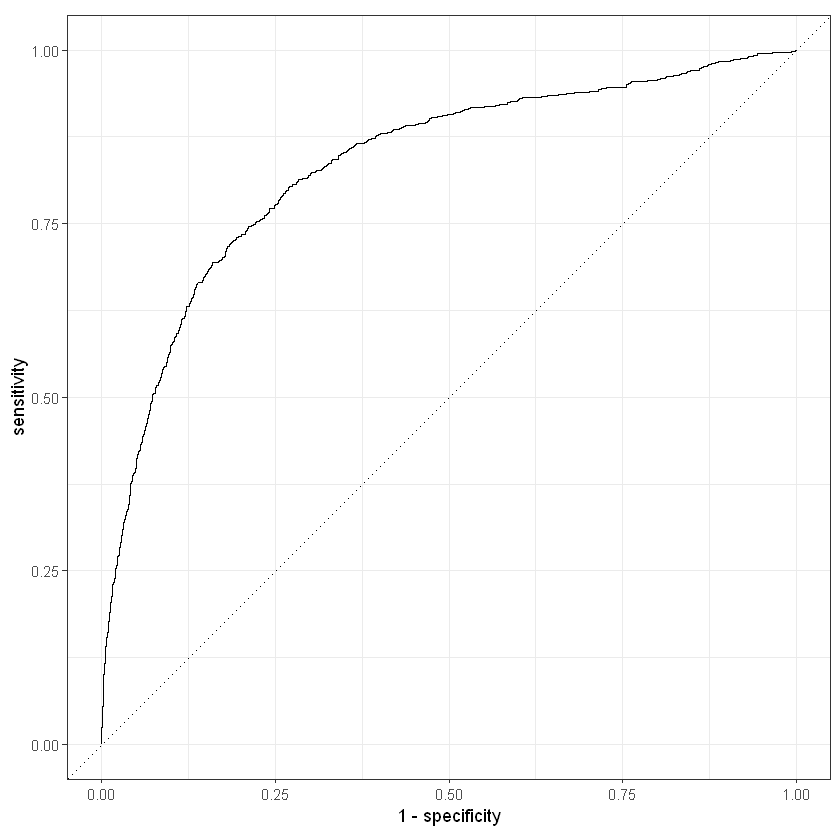

In [ ]:
logis_auc <- 
  logis_res %>% 
  collect_predictions(parameters = logis_best) %>% 
  roc_curve(attrition, .pred_Yes) %>% 
  mutate(model = "Logistic Regression")

autoplot(logis_auc)

### Second Model: Tree-Based Random Forest


#### Create the RF Recipe

In [ ]:
rf_rec <- 
  recipe(attrition ~ ., data = train_data) %>%
  step_dummy(all_nominal_predictors()) %>%
  step_zv(all_numeric()) %>%
  step_smote(attrition, over_ratio = 0.9, seed = 31967) %>%
  step_normalize(all_numeric()) 

rf_rec_prep <- rf_rec %>% prep() %>% juice()

#### Build the RF Model

In [ ]:
rf_mod <- 
  rand_forest(mtry = tune(), 
              min_n = tune(),
              trees = tune()
              ) %>% 
  set_engine("ranger",  importance = "impurity") %>% 
  set_mode("classification")

#### Create the RF worklow

In [ ]:
rf_workflow <- 
  workflow() %>% 
  add_model(rf_mod) %>% 
  add_recipe(rf_rec) 

#### Train and tune the RF model

Let's use grid = 20 without thinking of the best values of mtry, min_n and trees.

In [ ]:
set.seed(31967)

rf_res <- 
  rf_workflow %>% 
  tune_grid(boot_strap,
            grid = 1,
            control = control_grid(save_pred = TRUE),
            metrics = metric_set(roc_auc))

rf_res %>% 
  unnest(.metrics) %>% 
  arrange(desc(.estimate))

Warning message:
"package 'ranger' was built under R version 4.3.1"


: 

: 

#### Find the best RF Model

In [ ]:
rf_res %>% 
  show_best(metric = "roc_auc")

#### ROC AUC Plot VS mtry, min_n and trees

In [ ]:
rf_res %>%
  collect_metrics() %>%
  filter(.metric == "roc_auc") %>%
  select(mean, min_n, mtry, trees) %>%
  pivot_longer(cols = c(mtry, min_n,trees),
    values_to = "value",
    names_to = "parameter"
  ) %>%
  ggplot(aes(value, mean, color = parameter)) +
  geom_point(show.legend = FALSE, size = 2) +
  facet_wrap(~parameter, scales = "free_x") +
  theme(
        legend.position = "right",
        strip.background = element_rect(fill = "#483248"),
        strip.text = element_text(color = "white", face = "bold", size = 10),
        plot.background = element_rect(colour = "gray"),
        plot.title.position = "panel",
        plot.title = element_text(size = 10, hjust = 0.5),
        plot.subtitle = element_text(size = 8),
        plot.caption.position = "plot",
        plot.caption = element_text(size = 6, color = "grey"),
        axis.text.y = element_text(size = 6)
      ) +
  labs(title = "The metrics for all models",
       x = NULL,
       y = "AUC")

By this grid we can get an idea of what is going on with the value of mtry, min_n and trees. It looks like lower values of mtry are good (below about 10) and higher values of min_n are good (above about 25).

#### Select the best RF Model

In [ ]:
rf_best <- 
  rf_res %>% 
  select_best(metric = "roc_auc")
rf_best

#### Finalize RF workflow

In [ ]:
 finalize_workflow(
  rf_workflow,
  rf_best
)

#### Collect Predictions

In [ ]:
rf_res %>% 
  collect_predictions()

#### Create the ROC Curve Data

In [ ]:
rf_auc <- 
  rf_res %>% 
  collect_predictions(parameters = rf_best) %>% 
  roc_curve(attrition, .pred_Yes) %>% 
  mutate(model = "Random Forest")

#### Plot ROC Curve logistic regression VS RF

- The ROC curve shows the trade-off between sensitivity and specificity.
- Classifiers that give curves closer to the top-left corner indicate a better performance. 
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [ ]:
bind_rows(rf_auc, logis_auc) %>% 
  ggplot(aes(x = 1 - specificity, y = sensitivity, col = model)) + 
  geom_path(lwd = 1.5, alpha = 0.8) +
  geom_abline(lty = 3) + 
  coord_equal() + 
  scale_color_viridis_d(option = "plasma", end = .6)

It looks like Logistic regression model is doing better than Rondom forest model, we have to be cautious about this statement.

The final fit will tell us what is going on.

### Final Logistic Regression Fit

In [ ]:
set.seed(31967)
final_logis_res <-
  logis_workflow %>%
  finalize_workflow(logis_best) %>%
  last_fit(HrAtt_data_split)

final_logis_res 

#### Collect Metrics Logistic Regression

In [ ]:
collect_metrics(final_logis_res)

confusion_matrix_logis <- collect_predictions(final_logis_res) %>%
  conf_mat(attrition, .pred_class)

#### Confusion Matrix Logistic Regression 

In [ ]:
collect_predictions(final_logis_res) %>%
  conf_mat(attrition, .pred_class) %>%
pluck(1) %>%
  as_tibble() %>%
  ggplot(aes(Truth, Prediction, alpha = n)) +
  geom_tile(show.legend = FALSE, fill = "orange") +
  geom_text(aes(label = n), colour = "#2F423D", alpha = 1, size = 7) +
  scale_x_discrete(position = "top", limits = c("Yes","No"))

#### Accuracy Logistic Regression 

In [ ]:
collect_predictions(final_logis_res) %>%
  metrics(attrition, .pred_class) %>%
  select(-.estimator) %>%
  filter(.metric == "accuracy") 

#### Confusion Matrix Logis Summary 

summary(confusion_matrix_logis)

Actually, I liked this result especially Kappa in pretty nice. sensitivity and specificity are somehow balanced, although the npv is higher than ppv.

Now let's move to Random Forest Final fit

### Final RF Fit

In [ ]:
set.seed(31967)

final_rf_fit <-
  rf_workflow %>%
  finalize_workflow(rf_best) %>%
  last_fit(HrAtt_data_split)

final_rf_fit

#### Collect Metrics RF

In [ ]:
collect_metrics(final_rf_fit)

cunfusion_matrix_rf <- collect_predictions(final_rf_fit) %>%
  conf_mat(attrition, .pred_class)

#### Confusion Matrix RF

In [ ]:
collect_predictions(final_rf_fit) %>%
  conf_mat(attrition, .pred_class) %>%
pluck(1) %>%
  as_tibble() %>%
  ggplot(aes(Truth, Prediction, alpha = n)) +
  geom_tile(show.legend = FALSE, fill = "orange") +
  geom_text(aes(label = n), colour = "#2F423D", alpha = 1, size = 7) +
  scale_x_discrete(position = "top", limits = c("Yes","No"))

#### Accuracy RF

In [ ]:
collect_predictions(final_rf_fit) %>%
  metrics(attrition, .pred_class) %>%
  select(-.estimator) %>%
  filter(.metric == "accuracy") 

#### Final RF ROC Curve

In [ ]:
final_rf_auc <- 
  rf_res %>% 
  collect_predictions(parameters = rf_best) %>% 
  roc_curve(attrition, .pred_Yes)



final_rf_auc %>%
  ggplot(aes(x = 1 - specificity, y = sensitivity)) +
  geom_path(lwd = 1, alpha = 0.8) +
  geom_abline(lty = 3) +
  coord_equal() +
  theme(
    legend.position = "top",
    plot.background = element_rect(colour = "steelblue", fill = "#825654"),
    panel.background = element_rect(colour = "steelblue", fill = "#825654"),
    plot.title.position = "panel",
    plot.title = element_text(
      size = 18,
      hjust = 0.5,
      color = "white"
    ),
    plot.subtitle = element_text(size = 8),
    plot.caption.position = "plot",
    plot.caption = element_text(size = 10, color = "grey"),
    axis.ticks.x = element_blank(),
    axis.text = element_text(size = 10, color = "White"),
    axis.title = element_text(size = 10, color = "White")
  ) +
  labs(
    title = "Final ROC Curve (Random Forest)",
    x = "False Positive Rate (1-Specificity)",
    y = "True Positive Rate (Sensitivity)",
    color = NULL
  )

#### Confusion Matrix RF Summary 

In [ ]:
summary(cunfusion_matrix_rf)

kappa <- summary(cunfusion_matrix_rf) %>%
  filter(.metric == "kap") %>% 
  select(.estimate) %>%
  pull() %>%
  round(3)

RF model is better in predicting the attrition NO and weak in predicting attrition YES, this is the effect of imbalanced target variable. I'm sure we can improve it more by training the model more.
or use another engine, but for now it is OK!

- Kappa `r kappa` need to work on it to be improved.

#### Plot Variable Importance

In [ ]:
final_rf_fit %>% 
  pluck(".workflow", 1) %>%   
  pull_workflow_fit() %>%
  vip(num_features = 20, geom = "col", horizontal = TRUE, 
    aesthetics = list(color = "black", fill = "#900B4D", size = 0.5)) +
      theme(
        plot.background = element_rect(fill = "#ECDF7C"),
        plot.title.position = "panel",
        plot.title = element_text(size = 18, hjust = 0.5),
        plot.caption.position = "plot",
        plot.caption = element_text(size = 8, color = "grey"),
        panel.background = element_rect(fill = "#FEFFF7"),
        panel.grid = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 14)
      ) +
  labs(
    title = "Variable Importance",
    caption = "Data Source: Kaggle IBM HR Employee Attrition",
    x = "Variables",
    y = "Importance"
  )

final_rf_fit %>% 
  pluck(".workflow", 1) %>%   
  pull_workflow_fit() %>% vi(num_features = 20)

Mainly the Over-time and stock options level are connected somehow to the Income. 

The variables 
- job_satisfaction_X4,
- job_involvement_X3 and
- environment_satisfaction_X3 are mainly talking about satisfaction which is, in my opinion, the most important factor in determining employee attrition.


### Conclusion

This Notebook concludes that to reduce attrition organizations should create some opportunities for the growth of their employees within the organizations by adopting new Innovative Technologies and Effective training programs.

-   Employee satisfaction is essential to any effective employee retention strategy - any good HR manager knows that. 

- HR professionals are needed to be flexible in their approach to developing, motivating, and retaining their human resource pool.

-   The management should skillfully communicate organization policies to their employee.

- To reduce the employee attrition rate, the company has to concentrate more on working conditions and safety measures. 

- From this Notebook, it is identified that lack of salary is the main factor that forces employees to take more Overtime and then leave their jobs. 

- To reduce the attrition rate, Organizations should create some opportunities for the growth of their employees and should also think of recruiting people who are in the vicinity of the organization area.